# X-ray detected Be star catalog

**Caden Gobat**<sup>1</sup> & **Hui Yang**<sup>1</sup>

<sup>1</sup>The George Washington University

## research note published at https://iopscience.iop.org/article/10.3847/2515-5172/ac8937

## an interactive website for plotting the multi-wavelength properties of the catalog can be found at https://home.gwu.edu/~kargaltsev/XDBS/

In [5]:
#import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, sympy, matplotlib as mpl
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, matplotlib as mpl

from astropy.io import fits, ascii as ascii_io, votable
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.table import Table
from gdpyc import GasMap, DustMap
#import mwdust
#combined19= mwdust.Combined19()

from scipy import stats, optimize
import math
from collections import Counter
from matplotlib.lines import Line2D

from astropy.table import Table, Column, MaskedColumn

#from asymmetric_uncertainty import AsymmetricUncertainty

import warnings
warnings.filterwarnings('ignore')

## Defining some functions 

In [228]:
def find_nearest(df, ind_col='_q', sep_col='_r', check=False, drop=False):
    
    '''
    dropping multiple matches for the source with the same ind_col column by keeping the nearest match of sep_col column
    '''

    print('Before cleaning multiple matches:', len(df), 'rows.')
    df_nearest = pd.DataFrame(columns=[ind_col])
    for i in df[ind_col].unique():
        df_sub = df.loc[df[ind_col]==i]
        instances = len(df_sub)
        if instances == 0:
            pass
        elif drop and i in drop:
            pass
        else:
            if check and instances>1:
                print(df_sub)
                
            df_src = df_sub.loc[df_sub[sep_col] ==min(df_sub[sep_col])]
            if len(df_src)>1:
                df_nearest = pd.concat([df_nearest, df_src.head(1)])
            else:
                df_nearest = pd.concat([df_nearest, df_src])
    print('After cleaning multiple matches:', len(df_nearest), 'rows.')
    return df_nearest

def bandshift(fluxA,bandA,bandB,Gamma=1.7):
    
    '''
    calculating the converted energy fluxes from bandA energy range to bandB energy range assuming a power-law spectrum with photon index Gamma
    '''
    
    a1,a2 = bandA
    b1,b2 = bandB
    if Gamma == 2:
        integral = lambda lower,upper : np.log(upper) - np.log(lower)
    else:
        integral = lambda lower,upper : (upper**(2-Gamma) - lower**(2-Gamma))/(2-Gamma)
    scalar = fluxA/integral(a1,a2)
    fluxB = scalar*integral(b1,b2)
    return fluxB

In [229]:
# Reading the BeSS catalog, obtained from http://basebe.obspm.fr/basebe/

BeSS = ascii_io.read("./data/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'hourangle').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
BeSS.pprint()

 #    Be star    Category      RA     ... Nb of spectra in BeSS       _RAJ2000            _DEJ2000     
                                      ...                               deg                 deg        
---- ---------- --------- ----------- ... --------------------- ------------------- -------------------
   1 BD+62 2346 Classical 00 01 24.70 ...                     3 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical 00 01 38.63 ...                    85 0.41095833333333326   60.44992222222222
   3  HD 225095 Classical 00 03 27.15 ...                   234  0.8631249999999999   55.55089722222222
   4      2 Cet Classical 00 03 44.39 ...                    95  0.9349583333333332 -17.335991666666665
   5     10 Cas Classical 00 06 26.54 ...                   292  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical 00 06 48.30 ...                     2  1.7012499999999997  60.600230555555555
 ...        ...       ...         ... ...                   ... 

## Updating optical coordinates of some Be stars after manual investigation, since some Be stars from the BeSS catalog have relatively large positional uncertainties (1"-5")

In [230]:

indexs =    [68,        42,         47,         49,         230,       237,        253,             274,        260,      296,     1630]

gaia_ras =  [13.02345,   12.142170,  12.306773,  12.374212,  14.400078,14.552446,  15.262034, 16.480222,  15.467899,19.633210,215.300650]
gaia_decs = [-72.434514, -73.042030, -73.193853, -73.182921, -72.326132,-72.513544,-72.116379,-72.064044,-72.392790,63.742520,-62.698914]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    #print(BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'])
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'] = ra, dec 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])
    
BeSS['conf_flag'] = 0

indexs =    [760,       767,           150,            215,            516,      857,       1410,           1478,          1604,           2074,         189,          681]

gaia_ras =  [80.124405, 80.69202723514,13.95320073136, 14.16150651198, 34.809579,83.920304, 165.62489467958,174.7414595,   207.40398070198,303.73052859, 14.08276055767,52.29341705985]
gaia_decs = [-69.532146,33.41604799076,-72.45357585484,-72.30366663757,57.184698,-66.864928,-60.81551722574,-63.4774941368,-42.47381501215,36.8535390968,-72.46714301601,31.36639996404]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])

indexs =    [1715,      1930,      139,      1375,            857,            1475,             79,          120,         226,              265,                   1243,           1331,        1574,     1926, 272]

gaia_ras =  [241.00907212776,274.692197,13.896433, 161.47374583153,83.92084433997, 174.58301532056,13.34460251277,13.72732352852,14.29036126271,15.9064071959,       133.34164824874,156.50072742424,198.54794100157,274.63838149679, 16.28199523735]
gaia_decs = [-47.47609855748,-13.910324,-72.485176, -59.95105371342,-66.86487936541,-63.34347837499,-72.19883641895,-72.45661959811,-72.44935286279,-72.02589539658,-46.03576523452,-57.82691748014,-63.37375307540,-13.75223648534, -72.19705622274]



for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])



       Be star         _RAJ2000  _DEJ2000 
                         deg       deg    
--------------------- --------- ----------
            X SMC X-3  13.02345 -72.434514
      RX J0048.5-7302  12.14217  -73.04203
      RX J0049.2-7311 12.306773 -73.193853
      RX J0049.5-7310 12.374212 -73.182921
CXOU J005736.2-721934 14.400078 -72.326132
      RX J0058.2-7231 14.552446 -72.513544
      RX J0101.0-7206 15.262034 -72.116379
      RX J0105.9-7203 16.480222 -72.064044
      RX J0101.8-7223 15.467899  -72.39279
            CAS GAM-1  19.63321   63.74252
           4U 1416-62 215.30065 -62.698914
       Be star             _RAJ2000        _DEJ2000   
                             deg             deg      
---------------------- --------------- ---------------
            [HP99] 946       80.124405      -69.532146
 Cl* NGC 1893 CUF 3104  80.69202723514  33.41604799076
      Cl* NGC 330 G 68  13.95320073136 -72.45357585484
Cl* NGC 330 ELS 004509  14.16150651198 -72.30366663757
          NGC

## Cross-matching to Gaia DR3 and Gaia eDR3 distance catalogs using 2"

In [231]:
v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

print('matching BeSS to gaiadr3')

Gaiadr3_BeSS_2as = v.query_region(BeSS, catalog="I/355/gaiadr3", radius="2s")
df = Gaiadr3_BeSS_2as[0].to_pandas()
Gaiadr3_matched = Gaiadr3_BeSS_2as[0]["_q","_r","Source","RA_ICRS","DE_ICRS","DR3Name","Plx","e_Plx","RPlx","PM","pmRA","e_pmRA","pmDE","e_pmDE","epsi","sepsi","RUWE","Dist","b_Dist","B_Dist","Gmag","e_Gmag","BPmag","e_BPmag","RPmag","e_RPmag","Teff"]
Gaiadr3_matched['Source'] = Gaiadr3_matched['Source'].astype(str)
df_gaiadr3 = Gaiadr3_matched.to_pandas()
df_gaiadr3 = df_gaiadr3.dropna(subset=['_r'])

# Removing Be stars that are matched to the same Gaia eDR3 sources, 
# those are mostly duplicated Be stars that have slightly different coordinates 
df_gaiadr3 = find_nearest(df_gaiadr3, ind_col='Source', sep_col='_r', check=False, drop=False)


print('matching to gaiadr3paramp to get the physical parameters (e.g., spectral types)')

Gaiaparamp_BeSS_2as = v.query_region(BeSS, catalog="I/355/paramp", radius="2s")
Gaiaparamp_matched = Gaiaparamp_BeSS_2as[0]["_q","_r","Source","Pstar","SpType-ELS"]
Gaiaparamp_matched['Source'] = Gaiaparamp_matched['Source'].astype(str)
df_gaiaparamp = Gaiaparamp_matched.to_pandas()

df_gaiaparamp = find_nearest(df_gaiaparamp, ind_col='Source', sep_col='_r', check=False, drop=False)


print('matching to gaiaedr3dist to get the distance info')

Gaiadist_BeSS_2as = v.query_region(BeSS, catalog="I/352/gedr3dis", radius="2s")
Gaiadist_matched = Gaiadist_BeSS_2as[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo"]#,"Flag"]
Gaiadist_matched['Source'] = Gaiadist_matched['Source'].astype(str)
df_gaiadist = Gaiadist_matched.to_pandas()

df_gaiadist = find_nearest(df_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)



matching BeSS to gaiadr3
Before cleaning multiple matches: 2485 rows.
After cleaning multiple matches: 2463 rows.
matching to gaiadr3paramp to get the physical parameters (e.g., spectral types)
Before cleaning multiple matches: 2236 rows.
After cleaning multiple matches: 2210 rows.
matching to gaiaedr3dist to get the distance info
Before cleaning multiple matches: 2327 rows.
After cleaning multiple matches: 2312 rows.


In [232]:
# Combing the matching results from Gaia dr3 and Gaia edr3dist

df_gaia_comb = pd.merge(df_gaiadr3, df_gaiaparamp, on='Source', how="outer")
df_gaia_comb = pd.merge(df_gaia_comb, df_gaiadist, on='Source', how="outer")
print(len(df_gaia_comb))
df_gaia_comb = df_gaia_comb.rename(columns={'_q':'_q_edr3dist','_r':'_r_edr3dist','_q_x':'_q','_r_x':'_r','_q_y':'_q_dr3par','_r_y':'_r_dr3par'})


# Calculating color BP-RP and absolute magnitude of BPmag

df_gaia_comb['BP-RP'] = df_gaia_comb['BPmag']-df_gaia_comb['RPmag']
df_gaia_comb['abs_BPmag'] = df_gaia_comb['BPmag']-5*(np.log10(df_gaia_comb['rgeo'])-1)

print(df_gaia_comb.columns)

print('The break down of Gaia dr3paramp spectral types:\n', Counter(df_gaia_comb['SpType-ELS']))

2463
Index(['Source', '_q', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'e_Plx',
       'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'sepsi',
       'RUWE', 'Dist', 'b_Dist', 'B_Dist', 'Gmag', 'e_Gmag', 'BPmag',
       'e_BPmag', 'RPmag', 'e_RPmag', 'Teff', '_q_dr3par', '_r_dr3par',
       'Pstar', 'SpType-ELS', '_q_edr3dist', '_r_edr3dist', 'rgeo', 'b_rgeo',
       'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'BP-RP', 'abs_BPmag'],
      dtype='object')
The break down of Gaia dr3paramp spectral types:
 Counter({'B': 1574, nan: 253, 'O': 214, '': 148, 'G': 135, 'unknown': 61, 'F': 34, 'A': 28, 'K': 10, 'M': 6})


## Cleaning the sources with multiple Gaia matches

In [233]:
df_gaia_comb['gaia_conf'] = 0

# dropping those multiple/unlikely matches with larger separations and no magnitude and distance measurements

num_before = len(df_gaia_comb)
print(f'Before cleaning matching, #: {num_before}')

print('Removing other matches if the nearest match has O or B type spectral class, #:') 

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        
        sep_min = min(df_sub['_r'])
        nearest_type = df_gaia_comb.loc[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] ==sep_min), 'SpType-ELS'].values[0]
        if nearest_type == 'O' or nearest_type == 'B':#.str.isin(['O','B']):
            
            drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min)].index
            #print(df_gaia_comb.loc[drop_idx])
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+1

num_remove1 = len(df_gaia_comb)
print(num_before-num_remove1)       


print('Removing unlikely matches that are not the nearest matches and they do not have valid absolute magitude and they do not have O or B type spectral class, #:') 

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        #'''
        sep_min = min(df_sub['_r'])
        drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min) & (df_gaia_comb['abs_BPmag'].isnull()) & (df_gaia_comb['SpType-ELS']!='O') & (df_gaia_comb['SpType-ELS']!='B') ].index
        #print(df_gaia_comb.loc[drop_idx])
        if len(drop_idx)>0:
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+2
        #'''
print(num_remove1-len(df_gaia_comb))

num_mul = 0
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        num_mul+= instances-1
        df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+4
        #'''
print(f'There are still {num_mul} Be star with multiple matches.')

Before cleaning matching, #: 2463
Removing other matches if the nearest match has O or B type spectral class, #:
203
Removing unlikely matches that are not the nearest matches and they do not have valid absolute magitude and they do not have O or B type spectral class, #:
71
There are still 25 Be star with multiple matches.


In [235]:
# We take the closest counterparts for those questionable matches with multiple gaia counterparts 
 
df_gaia = find_nearest(df_gaia_comb, ind_col='_q', sep_col='_r')

print(Counter(df_gaia['gaia_conf']))
print(df_gaia.columns)

Before cleaning multiple matches: 2189 rows.
After cleaning multiple matches: 2164 rows.
Counter({0.0: 1941, 1.0: 165, 2.0: 35, 4.0: 14, 6.0: 9})
Index(['_q', 'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'e_Plx',
       'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'sepsi',
       'RUWE', 'Dist', 'b_Dist', 'B_Dist', 'Gmag', 'e_Gmag', 'BPmag',
       'e_BPmag', 'RPmag', 'e_RPmag', 'Teff', '_q_dr3par', '_r_dr3par',
       'Pstar', 'SpType-ELS', '_q_edr3dist', '_r_edr3dist', 'rgeo', 'b_rgeo',
       'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'BP-RP', 'abs_BPmag',
       'gaia_conf'],
      dtype='object')


In [236]:
# Combining BeSS catalog and gaia catalog 

df_BeSS = BeSS.to_pandas()
#print(df_BeSS.head)
df_comb = pd.merge(df_BeSS[['#','Be star','_RAJ2000', '_DEJ2000','V','Type','vsini','conf_flag']], df_gaia.drop(columns=['_q_dr3par','_r_dr3par','_q_edr3dist', '_r_edr3dist']), left_on="#", right_on="_q", how="outer")
#print(df_comb.columns)

# Using Gaia coordinates rather than BeSS coordinates, unless there is no Gaia match for BeSS stars
print(len(df_comb))
df_comb['RA'], df_comb['DEC'] = df_comb['RA_ICRS'], df_comb['DE_ICRS']
print(len(df_comb[df_comb['RA'].isnull()]))
#print(len(df_comb[df_comb['DEC'].isnull()]))
df_comb.loc[df_comb['RA'].isnull(), 'RA'] = df_comb.loc[df_comb['RA'].isnull(), '_RAJ2000']
df_comb.loc[df_comb['DEC'].isnull(), 'DEC'] = df_comb.loc[df_comb['DEC'].isnull(), '_DEJ2000']

df_comb.to_csv('./data/BeSS2Gaia.csv',index=False)

2264
100


In [237]:
BeSS = ascii_io.read("./data/BeSS2Gaia.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'deg').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
#BeSS.pprint()

## Forward-matching to X-ray catalogs

In [238]:
# matching to X-ray catalogs, for 2SXPS we use the 2sxps version rather than 2sxpscle clean version

cat_ids = ["IX/57/csc2master","IX/65/xmm4d11s","IX/58/2sxps"] 
Xmatch = [None, None, None]
radii = ["2s","5s","9s"]
for i in range(len(cat_ids)):
    Xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[CSC_xmatch, XMM_xmatch, XRT_xmatch] = Xmatch

Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/65/xmm4d11s
Successfully matched BeSS with IX/58/2sxps


In [239]:
Chandra_sources = CSC_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","r0","_2CXO","S_N", 'HRhm', 'HRhs', 'HRms',
                                'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs',
                                'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL'].to_pandas()
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","ePos","_4XMM",'srcML','Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4'].to_pandas()
#xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))
xmm_bands = dict(zip(list("2345"),[(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0)]))

XRT_sources = XRT_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","Err90",'_2SXPS','Det','t.exp','Ct0','Ct1','Ct2','Ct3','Warning','CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'E_FPO0','e_FPO0','FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'].to_pandas()


In [240]:
# checking the multiple matches from X-ray catalogs 

for df in [Chandra_sources, XMM_sources, XRT_sources]:

    print(df[df.duplicated(subset=['_q'], keep=False)])

    
# taking the closest counterpart
df_CSC = find_nearest(Chandra_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XMM = find_nearest(XMM_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XRT = find_nearest(XRT_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)

      _q     _r    _RAJ2000   _DEJ2000     r0              _2CXO     S_N  \
36   892  0.834   84.727452  26.315550  1.403  J053854.5+261855X  27.094   
37   892  0.198   84.727417  26.315725  0.710   J053854.5+261856  89.197   
44  1376  1.084  161.473743 -59.951355  0.721   J104553.6-595704  16.614   
45  1376  0.069  161.473733 -59.951072  0.721   J104553.6-595703   4.158   
49  1456  0.321  172.778935 -62.946932  0.713   J113106.9-625648  20.855   
50  1456  0.885  172.779145 -62.946756  2.002  J113106.9-625648X  13.580   

       HRhm     HRhs     HRms  ...         Fluxs       B_Fluxs       b_Fluxs  \
36      NaN      NaN      NaN  ...           NaN           NaN           NaN   
37  0.58339  0.77327  0.34603  ...  6.522526e-14  6.806354e-14  6.238699e-14   
44      NaN      NaN      NaN  ...  0.000000e+00  2.921220e-15  0.000000e+00   
45  0.18988 -0.24110 -0.40350  ...  2.094771e-15  2.894592e-15  1.256862e-15   
49  0.67208  0.93067  0.68582  ...  1.292182e-14  1.748246e-14  8.1

In [241]:
# merging X-ray catalog matching results

xray = pd.merge(df_CSC, df_XMM, on="_q", how="outer")
xray = pd.merge(xray, df_XRT, on="_q", how="outer")

print(len(xray))

# renaming some columns 

xray.rename(columns={'_r_x':'_r_CSC','_RAJ2000_x':'_RAJ2000_CSC','_DEJ2000_x':'_DEJ2000_CSC',
                     '_r_y':'_r_XMM','_RAJ2000_y':'_RAJ2000_XMM','_DEJ2000_y':'_DEJ2000_XMM',
                     '_r':'_r_XRT','_RAJ2000':'_RAJ2000_XRT','_DEJ2000':'_DEJ2000_XRT',"HR1_x":"HR1","HR2_x":"HR2","HR1_y":"HR1_XRT","HR2_y":"HR2_XRT"},inplace=True)

#print(xray.columns)

185


In [242]:
CSC_fluxs = ['Fluxs', 'Fluxm', 'Fluxh']
CSC_fluxs_err = ['B_Fluxs','b_Fluxs','B_Fluxm','b_Fluxm','B_Fluxh','b_Fluxh']
XMM_fluxs = ['Flux2', 'Flux3', 'Flux4', 'Flux5']
XMM_fluxs_err = ['e_Flux2', 'e_Flux3', 'e_Flux4', 'e_Flux5']
XRT_fluxs = ['FPO0']
XRT_fluxs_err = ['E_FPO0','e_FPO0']

for i,row in xray.iterrows():
    flag = []
    if pd.notna(row["_2CXO"]):
        flag.append("CXO")
    if pd.notna(row["_4XMM"]):
        flag.append("XMM")
    if pd.notna(row["_2SXPS"]):
        flag.append("XRT")
    flag = "+".join(flag)
    if len(flag)<3:
        flag = np.nan
    xray.loc[i,"Flag"] = flag


xray.dropna(subset=["Flag"],inplace=True)
# replacing zero flux with a very small flux to avoid zero denominator issue
xray[CSC_fluxs+CSC_fluxs_err+XMM_fluxs+XMM_fluxs_err+XRT_fluxs+XRT_fluxs_err] = xray[CSC_fluxs+CSC_fluxs_err+XMM_fluxs+XMM_fluxs_err+XRT_fluxs+XRT_fluxs_err].replace(0,1.0e-20)

xray["Flag"].value_counts()

XMM            55
CXO+XMM+XRT    32
XRT            30
CXO            22
XMM+XRT        21
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64

In [243]:
# Determining X-ray coordinates in priority of CSC -> XMM -> XRT

xray['X_pos'] = 'CXO'
xray['_RAJ2000_X'] = xray['_RAJ2000_CSC']
xray['_DEJ2000_X'] = xray['_DEJ2000_CSC']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XMM'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XMM'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XMM']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XRT'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XRT'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XRT']


## Converting X-ray fluxes

In [244]:
# Determining X-ray fluxes at CXO s,m,h bands in priority of CSC -> XMM -> XRT
# X_pos and X_flux are not necessarily coming from the same X-ray catalog since some X-ray catalog has the valid coordinate but the fluxes might be Null

for i in xray[xray["_2CXO"].notna() | xray["_4XMM"].notna() | xray["_2SXPS"].notna()].index:
    
    cxoflux, xmmflux, xrtflux = xray.loc[i,CSC_fluxs].values, xray.loc[i,XMM_fluxs].values, xray.loc[i,XRT_fluxs].values
    exists = False
    
    if pd.notna(xray.loc[i,"GamPL"]): # spectral index from Chandra
        Gamma_use = float(xray.loc[i,"GamPL"])
        Gamma = AsymmetricUncertainty(Gamma_use,abs(xray.loc[i,"B_GamPL"]-Gamma_use),abs(Gamma_use-xray.loc[i,"b_GamPL"]))
        exists = True
    elif pd.notna(xray.loc[i,"Gam1"]): # spectral index from Swift
        Gamma_use = float(xray.loc[i,"Gam1"])
        Gamma = AsymmetricUncertainty(Gamma_use ,abs(xray.loc[i,"E_Gam1"]),abs(xray.loc[i,"e_Gam1"]))
        exists = True
    else: # assumption for general case
        Gamma_use = 1.7
        
    
    if all(pd.notna(cxoflux)) and ~((cxoflux[0]==1e-20) and (cxoflux[1]==1e-20) and (cxoflux[1]==1e-20)): # good Chandra observations present
        
        #print(cxoflux)
        pos_err = xray.loc[i,["B_Fluxs","B_Fluxm","B_Fluxh"]] - cxoflux
        neg_err = cxoflux - xray.loc[i,["b_Fluxs","b_Fluxm","b_Fluxh"]]
        converted = []
        for j in range(3):
            converted.append(AsymmetricUncertainty(cxoflux[j],pos_err[j],neg_err[j]))
        source = "CXO"
        
    elif all(pd.notna(xmmflux)) and ~((xmmflux[0]==1e-20) and (xmmflux[1]==1e-20) and (xmmflux[2]==1e-20) and (xmmflux[3]==1e-20)): # no Chandra, but good XMM

        xmmerr = xray.loc[i,["e_"+band for band in XMM_fluxs]]

        mergedxmm = np.array([AsymmetricUncertainty(xmmflux[0],xmmerr[0],xmmerr[0]),
                              AsymmetricUncertainty(xmmflux[1],xmmerr[1],xmmerr[1]),
                              AsymmetricUncertainty(xmmflux[2],xmmerr[2],xmmerr[2])+AsymmetricUncertainty(xmmflux[3],xmmerr[3],xmmerr[3])])
        origbands = [(0.5,1),(1,2),(2,12)]
        converted = [bandshift(flux,xmmband,cxoband,Gamma_use) for flux,xmmband,cxoband in
                     zip(mergedxmm,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XMM"
        
    elif all(pd.notna(xrtflux)) and (xrtflux[0]>1e-20): # neither Chandra nor XMM, but good Swift-XRT
        #print(xrtflux[0])
        pos_err = xray.loc[i,"E_FPO0"]
        neg_err = xray.loc[i,"e_FPO0"]
        origbands = [(0.3,10),(0.3,10),(0.3,10)]
        converted = [bandshift(flux,xrtband,cxoband,Gamma_use) for flux,xrtband,cxoband in
                     zip([AsymmetricUncertainty(xrtflux,abs(pos_err),abs(neg_err))]*3,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XRT"
        
    else:
        converted = np.nan
        source = np.nan
        continue
    
    
    for j,b in enumerate("smh"):
        xray.loc[i,f"Flux_{b}"]   = converted[j].value
        xray.loc[i,f"E_Flux_{b}"] = converted[j].plus
        xray.loc[i,f"e_Flux_{b}"] = converted[j].minus
    
    xray.loc[i,"X_flux"] = source
    if exists:
        xray.loc[i,"Gamma"] = Gamma.value
        xray.loc[i,"E_Gamma"] = Gamma.plus
        xray.loc[i,"e_Gamma"] = Gamma.minus
        

In [245]:
for j, band in enumerate("smh"):
    xray.loc[xray[f"Flux_{band}"]<1e-19, f"Flux_{band}"] = 1e-20 
    xray.loc[xray[f"e_Flux_{band}"]<1e-19, f"e_Flux_{band}"] = 1e-20 

In [246]:
print('dropping those with invalid X-ray fluxes')
print(xray.loc[xray["X_flux"].isna(), ['_q', '_2CXO',  'Flag', '_RAJ2000_X', '_DEJ2000_X']+CSC_fluxs+XMM_fluxs+XRT_fluxs+\
                                 ['Flux_s', 'Flux_m', 'Flux_h', 'X_flux', 'Gamma']])
xray = xray.dropna(subset=['X_flux']).reset_index(drop=True)
print(len(xray))

dropping those with invalid X-ray fluxes
         _q             _2CXO Flag  _RAJ2000_X  _DEJ2000_X         Fluxs  \
23    514.0  J021856.8+570742  CXO   34.736726   57.128502           NaN   
51   1608.0  J135217.3-662415  CXO  208.072096  -66.404350  5.611409e-16   
53   1703.0  J155355.8-235841  CXO  238.482763  -23.978212  9.810809e-14   
54   1758.0  J163709.5-103401  CXO  249.289841  -10.567142  1.486114e-12   
156     121               NaN  XRT   13.726900  -72.454910           NaN   
158     227               NaN  XRT   14.288530  -72.447910           NaN   
171    1332               NaN  XRT  156.503590  -57.825920           NaN   
179    1927               NaN  XRT  274.637350  -13.752170           NaN   

            Fluxm         Fluxh  Flux2  Flux3  Flux4  Flux5          FPO0  \
23            NaN  1.000000e-20    NaN    NaN    NaN    NaN           NaN   
51   3.745817e-16           NaN    NaN    NaN    NaN    NaN           NaN   
53   8.055015e-14           NaN    NaN    N

In [247]:
print(xray[['X_flux']].value_counts())
print(xray.groupby(['X_flux','Flag']).size())


X_flux
XMM       83
CXO       67
XRT       27
dtype: int64
X_flux  Flag       
CXO     CXO            18
        CXO+XMM        15
        CXO+XMM+XRT    26
        CXO+XRT         8
XMM     CXO+XMM         1
        CXO+XMM+XRT     6
        XMM            55
        XMM+XRT        21
XRT     CXO+XRT         1
        XRT            26
dtype: int64


## Backward-matching X-ray sources to Gaia

In [248]:
v = Vizier(columns=['all', '_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

radec = [[xray.loc[j,'_RAJ2000_X'], xray.loc[j, '_DEJ2000_X']] for j in range(len(xray))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

# matching to gaiadr3
X_ga = v.query_region(rd, catalog="I/355/gaiadr3", radius='9s')[0]
X_ga['Source'] = X_ga['Source'].astype(str)
X_ga = X_ga.to_pandas()
X_ga = find_nearest(X_ga, ind_col='Source', sep_col='_r', check=False, drop=False)
print(len(X_ga))

# matching to gaiadr3paramp
X_gapar = v.query_region(rd, catalog="I/355/paramp", radius="9s")[0]["_q","_r","Source","Pstar","SpType-ELS"]
X_gapar['Source'] = X_gapar['Source'].astype(str)
X_gapar = X_gapar.to_pandas()
X_gapar = find_nearest(X_gapar, ind_col='Source', sep_col='_r', check=False, drop=False)
X_gaia = pd.merge(X_ga, X_gapar, on='Source', how="outer")
print(len(X_gaia))

# matching to gaiaedr3dist
X_gaiadist = v.query_region(rd, catalog="I/352/gedr3dis", radius='9s')[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]
X_gaiadist['Source'] = X_gaiadist['Source'].astype(str)
X_gaiadist = X_gaiadist.to_pandas()
X_gaiadist = find_nearest(X_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)
X_gaia = pd.merge(X_gaia, X_gaiadist, on='Source', how="outer")
print(len(X_gaia))

#print(X_gaia.columns)
X_gaia = X_gaia.rename(columns={'_q':'_q_edr3dist','_r':'_r_edr3dist','_q_x':'_q','_r_x':'_r','_q_y':'_q_dr3par','_r_y':'_r_dr3par'})
#X_gaia['BP-RP'] = X_gaia['BPmag']-X_gaia['RPmag']
X_gaia['abs_BPmag'] = X_gaia['BPmag']-5*(np.log10(X_gaia['rgeo'])-1)


Before cleaning multiple matches: 1101 rows.
After cleaning multiple matches: 1096 rows.
1096
Before cleaning multiple matches: 777 rows.
After cleaning multiple matches: 770 rows.
1096
Before cleaning multiple matches: 837 rows.
After cleaning multiple matches: 833 rows.
1096


In [249]:
#print(len(xray))
print(xray['X_pos'].value_counts())
#xray['X_pos']
print(xray["Flag"].value_counts())
print(xray.groupby(['X_pos','Flag']).size())
#print(xray[xray.X_pos=='CXO'])

XMM    76
CXO    75
XRT    26
Name: X_pos, dtype: int64
XMM            55
CXO+XMM+XRT    32
XRT            26
XMM+XRT        21
CXO            18
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64
X_pos  Flag       
CXO    CXO            18
       CXO+XMM        16
       CXO+XMM+XRT    32
       CXO+XRT         9
XMM    XMM            55
       XMM+XRT        21
XRT    XRT            26
dtype: int64


In [250]:
# cleaning matches outside corresponding X-ray error circles since I used 9" for all matches for convenience

print('Before cleaning matches outside X-ray error circles:',len(X_gaia))  

search_radii = {'CXO': 2, 'XMM':5, 'XRT':9}

for i in X_gaia['_q'].unique():
    
    drop_idx = X_gaia[(X_gaia['_q'] == i) & (X_gaia['_r'] > search_radii[xray.loc[i-1, 'X_pos']] ) ].index

    X_gaia.drop(drop_idx, inplace = True)


print('After cleaning matches outside X-ray error circles:',len(X_gaia))

Before cleaning matches outside X-ray error circles: 1096
After cleaning matches outside X-ray error circles: 450


In [251]:
df_BeSS

,#,Be star,Category,RA,DEC,V,Type,vsini,Nb of spectra in BeSS,_RAJ2000,_DEJ2000,conf_flag
0,1,BD+62 2346,Classical,00 01 24.70,63 30 15.73,9.730,B0Ve,<NA>,3,0.352917,63.504369,0
1,2,HD 224905,Classical,00 01 38.63,60 26 59.72,8.470,B1Vne,<NA>,85,0.410958,60.449922,0
2,3,HD 225095,Classical,00 03 27.15,55 33 03.23,7.950,B2IVne,<NA>,234,0.863125,55.550897,0
3,4,2 Cet,Classical,00 03 44.39,-17 20 09.57,4.543,B9IVne,<NA>,95,0.934958,-17.335992,0
4,5,10 Cas,Classical,00 06 26.54,64 11 46.21,5.567,B9IIIe,125,292,1.610583,64.196169,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2259,2260,BD+65 1970,Classical,23 57 34.10,66 25 53.84,10.170,B5e,<NA>,1,359.392083,66.431622,0
2260,2261,LQ And,Classical,23 58 46.44,46 24 47.44,6.542,B4Vne,300,507,359.693500,46.413178,0
2261,2262,HD 224544,Classical,23 58 49.24,32 22 54.14,6.524,B6IVe,260,402,359.705167,32.381706,0
2262,2263,HD 224599,Classical,23 59 14.97,60 01 20.93,9.700,B0.5Vnnpe,<NA>,2,359.812375,60.022481,0


    _RAJ2000_X  _DEJ2000_X X_pos
27   52.293231   31.366406   CXO
       #          Be star   _RAJ2000  _DEJ2000
681  682  GSC 02342-00359  52.293417   31.3664
    _RAJ2000_X  _DEJ2000_X X_pos
31   80.691446     33.4163   CXO
       #                Be star   _RAJ2000   _DEJ2000
767  768  Cl* NGC 1893 CUF 3104  80.692027  33.416048
    _RAJ2000_X  _DEJ2000_X X_pos
76   13.955317  -72.452594   XMM
       #           Be star   _RAJ2000   _DEJ2000
150  151  Cl* NGC 330 G 68  13.953201 -72.453576
    _RAJ2000_X  _DEJ2000_X X_pos
77   14.158752  -72.302808   XMM
       #                 Be star   _RAJ2000   _DEJ2000
215  216  Cl* NGC 330 ELS 004509  14.161507 -72.303667
     _RAJ2000_X  _DEJ2000_X X_pos
111  165.625379   -60.81516   XMM
         #    Be star    _RAJ2000   _DEJ2000
1410  1411  HD 305891  165.624895 -60.815517
     _RAJ2000_X  _DEJ2000_X X_pos
112  174.582971  -63.342137   XMM
         #   Be star    _RAJ2000   _DEJ2000
1475  1476  V870 Cen  174.583015 -63.343478
     _RAJ200

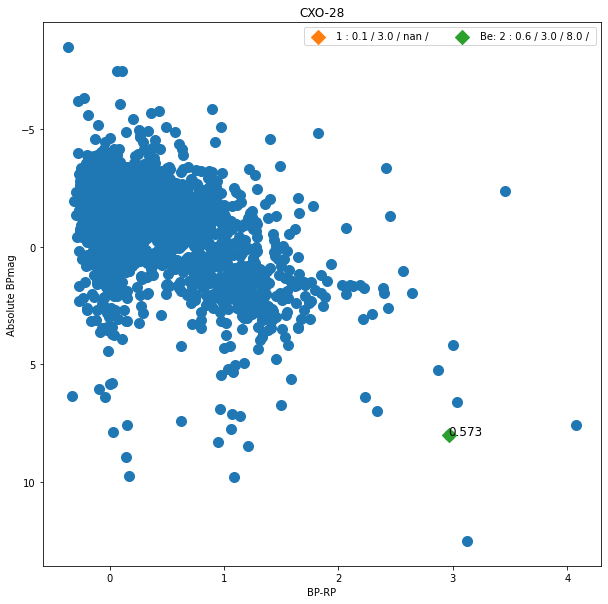

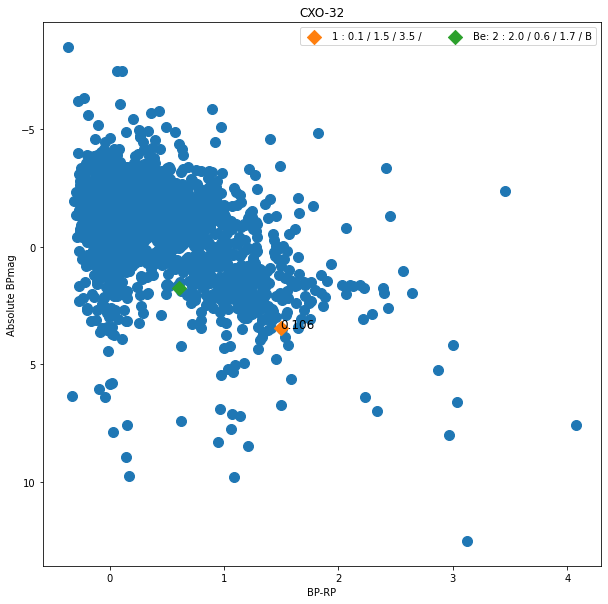

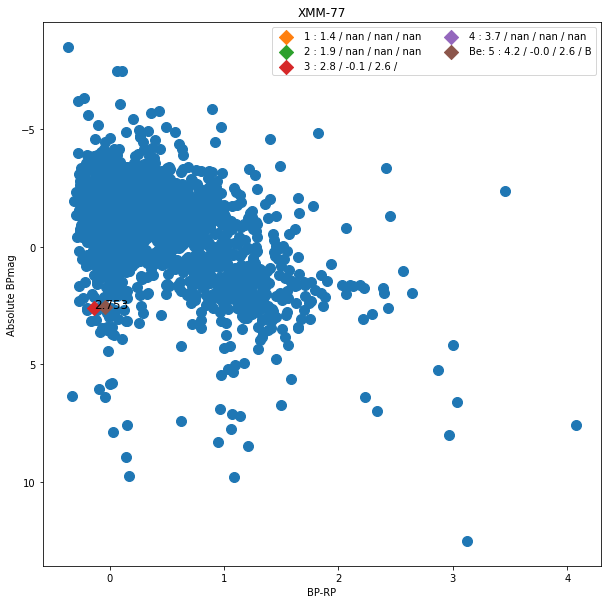

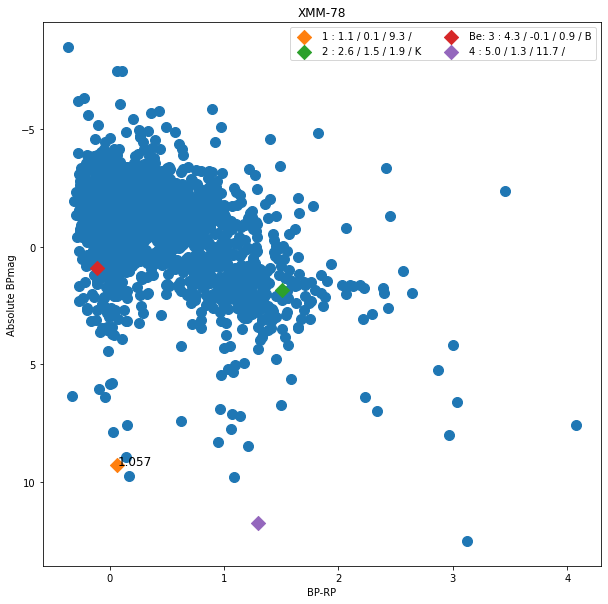

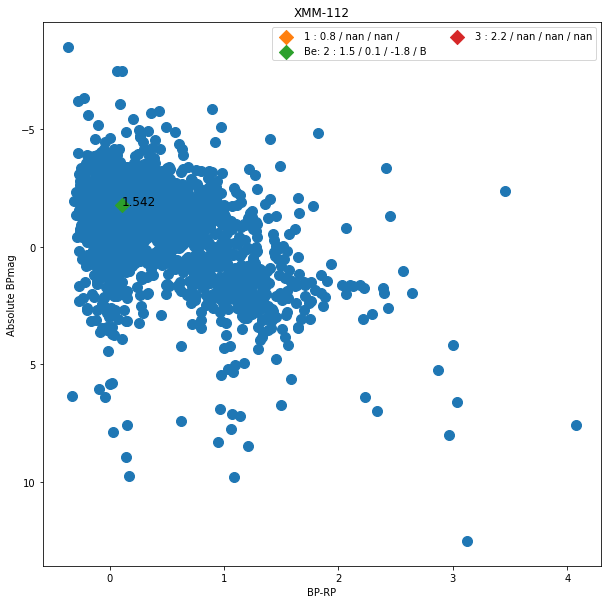

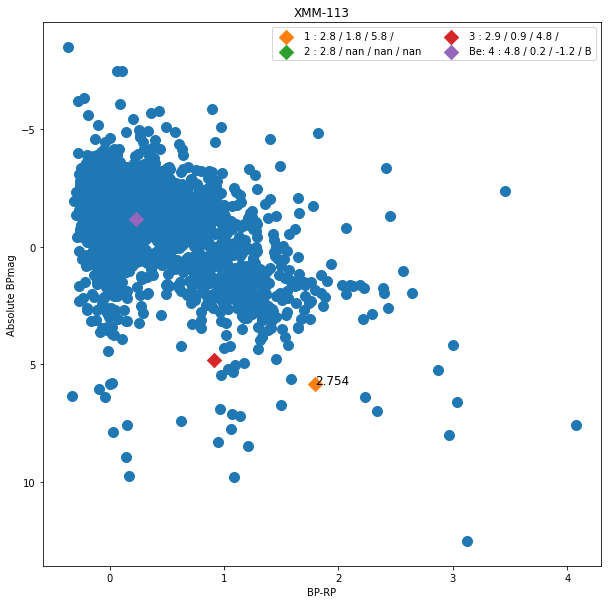

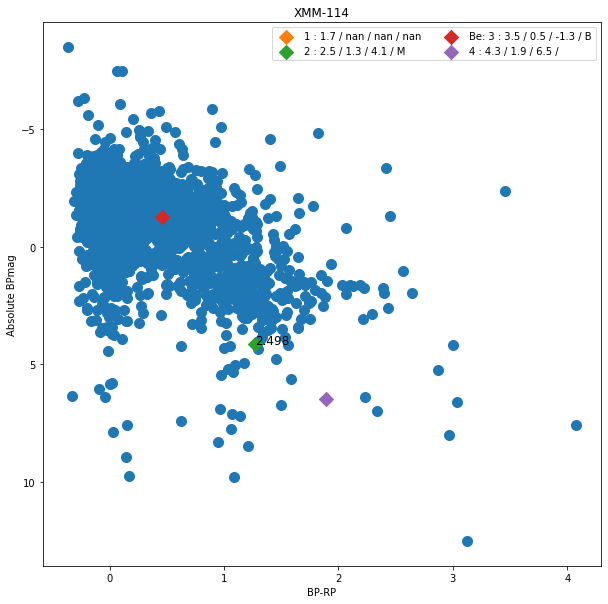

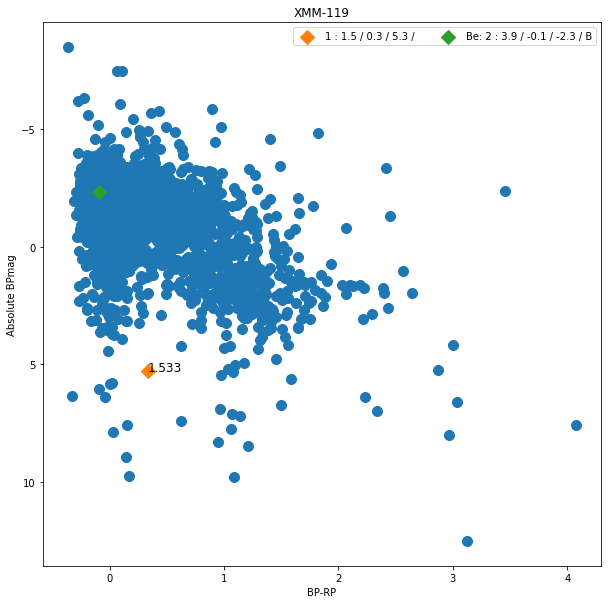

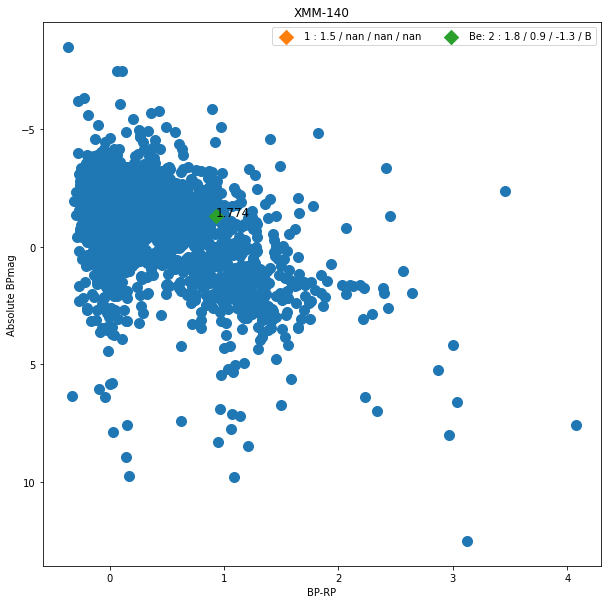

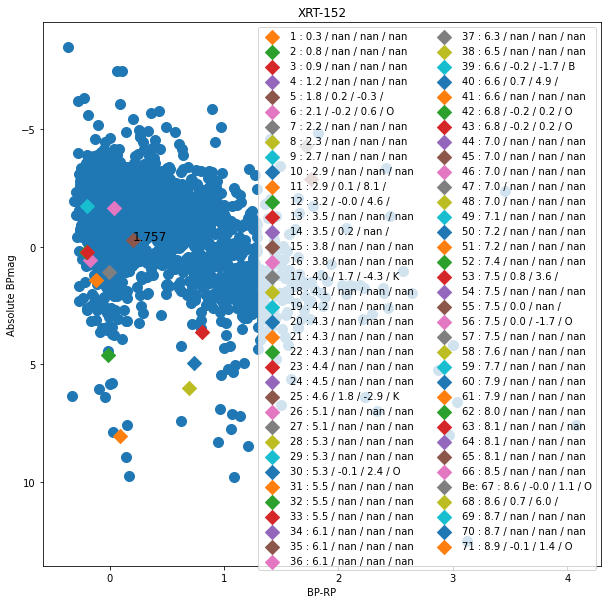

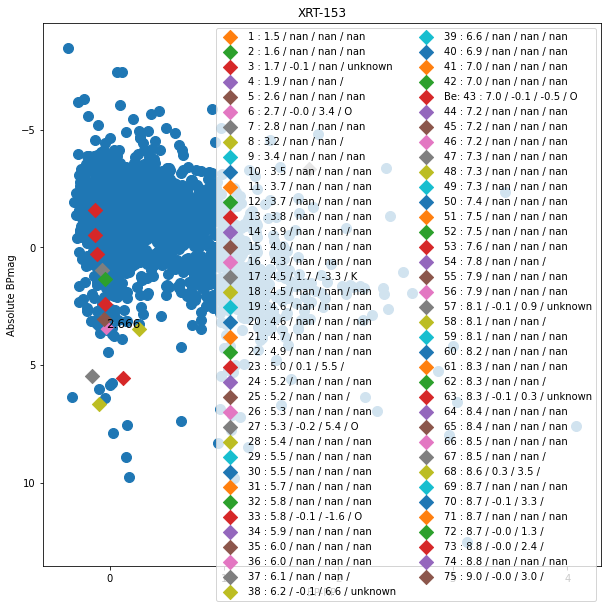

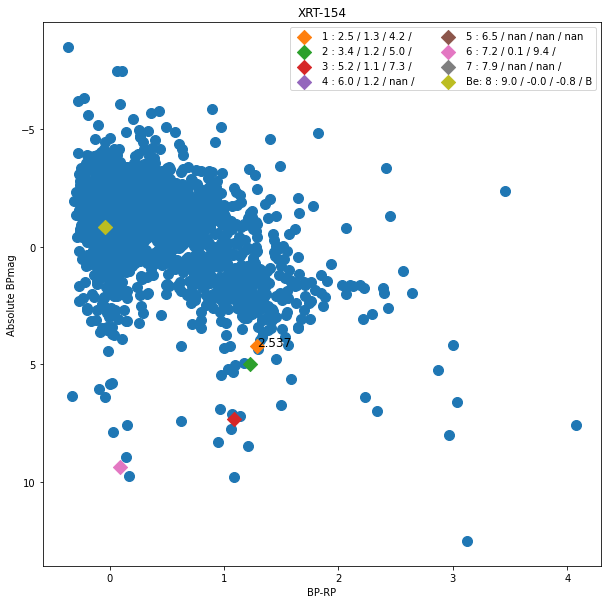

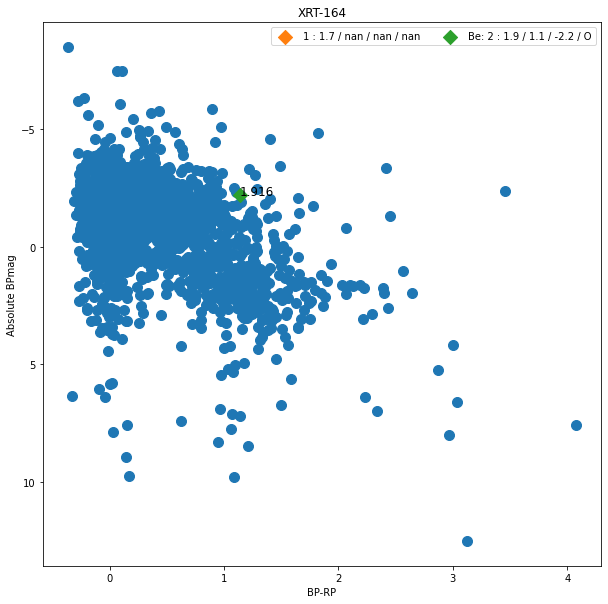

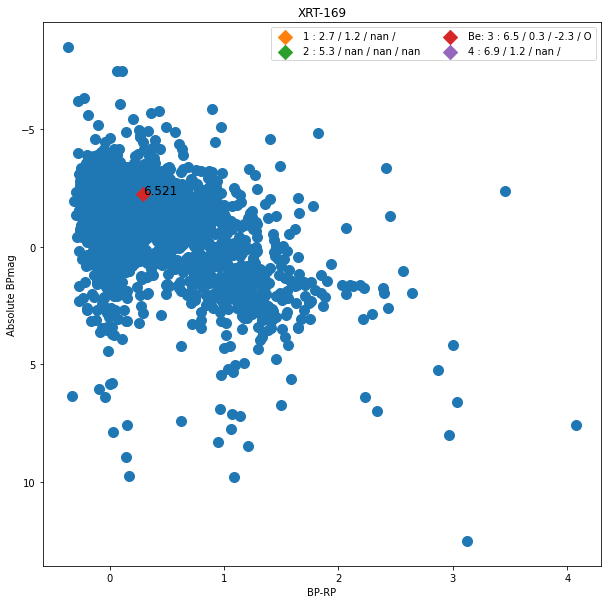

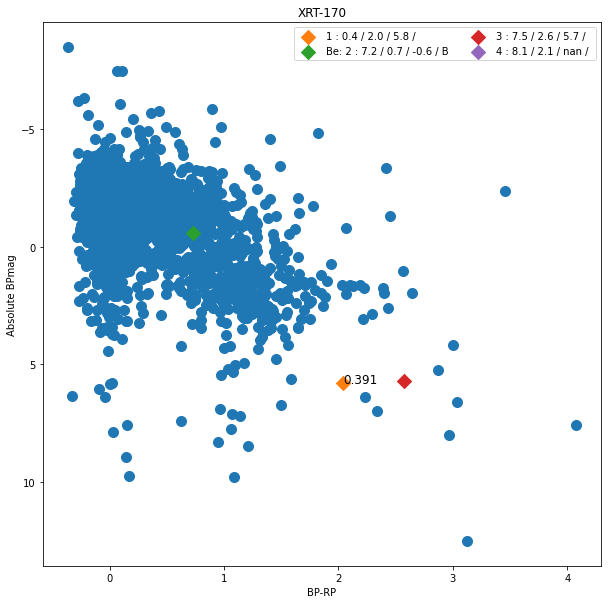

In [252]:
# marking questionable gaia counterparts of X-ray sources with multiple matches using conf_flag_X2O column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots
# selecting the nearest gaia matches with valid color and distance measurements (plotted along with their separation in ")

X_gaia_select = pd.DataFrame()

for i in X_gaia['_q'].unique():

    df_sub = X_gaia.loc[X_gaia['_q']==i].sort_values(by=['_r'])
    instances = len(df_sub)
    if instances == 1:
        df_sub['conf_flag_X2O'] = 0
        X_gaia_select = X_gaia_select.append(df_sub, ignore_index=True)
    else:
        df_src = df_sub.loc[df_sub['_r'] ==min(df_sub['_r'])]
        if len(df_src)>1:
            df_nearest = df_src.head(1)
        else:
            df_nearest = df_src
            
        if df_nearest['Source'].values in df_gaia['Source'].values:
            df_nearest['conf_flag_X2O'] = 1
            X_gaia_select = X_gaia_select.append(df_nearest, ignore_index=True)
        
        if df_nearest['Source'].values not in df_gaia['Source'].values:
            print(xray.loc[xray.index==i-1, ['_RAJ2000_X','_DEJ2000_X','X_pos']])
            
            fig, ax = plt.subplots(figsize=(10,10))

            ax.scatter(df_gaia['BP-RP'], df_gaia['abs_BPmag'], s=100)

            j=1
            for s in df_sub.index:
                
                if df_sub.loc[s, 'Source'] in df_gaia['Source'].values:
                    print(df_comb.loc[df_comb.Source== df_sub.loc[s, 'Source'],['#','Be star','_RAJ2000', '_DEJ2000']])
                    
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="Be: %1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                else:
                
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="%1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                j+=1
            
            df_sub_select = df_sub[(~df_sub['BP-RP'].isnull()) & (~df_sub['abs_BPmag'].isnull())].iloc[0]
            df_sub_select['conf_flag_X2O'] = 2
            X_gaia_select = X_gaia_select.append(df_sub_select, ignore_index=True)
            # #print(df_sub_select)
            ax.text(df_sub_select['BP-RP'], df_sub_select['abs_BPmag'], str(df_sub_select['_r']), fontsize=12)
                
                
            plt.legend(ncol=2,fontsize=10)
            plt.gca().invert_yaxis()
            plt.xlabel('BP-RP')
            plt.ylabel('Absolute BPmag')
            plt.title(xray.loc[i-1, 'X_pos']+'-'+str(int(i)))

        
#print(cat,'\n')       

In [253]:
#print(Counter(X_gaia_select['conf_flag_X2O']))
print(xray.columns)

Index(['_q', '_r_CSC', '_RAJ2000_CSC', '_DEJ2000_CSC', 'r0', '_2CXO', 'S_N',
       'HRhm', 'HRhs', 'HRms',
       ...
       'Flux_m', 'E_Flux_m', 'e_Flux_m', 'Flux_h', 'E_Flux_h', 'e_Flux_h',
       'X_flux', 'Gamma', 'E_Gamma', 'e_Gamma'],
      dtype='object', length=104)


In [254]:
df_BeSS_Gaia = pd.read_csv("./data/BeSS2Gaia.csv")

xray = xray.drop(columns=['_RAJ2000_CSC', '_DEJ2000_CSC','_RAJ2000_XMM', '_DEJ2000_XMM','_RAJ2000_XRT', '_DEJ2000_XRT'])#.rename(columns={'_RAJ2000':'_RAJ2000_X', '_DEJ2000':'_DEJ2000_X'})
xray['index_X'] = xray.index+1

print('merging all three (gaia, xray and BeSS) tables')
#print(len(xray))
#print(len(xray['_q'].unique()))
#print(xray.loc[~(xray['_q'].isin(df_BeSS_Gaia['_q'])) ,['_q']])
master = pd.merge(df_BeSS_Gaia, xray, left_on='#',right_on='_q', how='inner')
#print(master.columns)
master = pd.merge(master, X_gaia_select[['_q','conf_flag_X2O']], left_on = 'index_X', right_on='_q', how='outer')
print(len(master))
#print(Counter(master['conf_flag_X2O']))

#master.to_csv('./data/master_BeSS_Xray_Gaia.csv', index=False) 

merging all three (gaia, xray and BeSS) tables
177


## Optical Loading 

In [255]:
print(master[['X_flux']].value_counts())
print(master.groupby(['X_flux','Flag']).size())

XRT_loading = master[(master['X_flux']=='XRT') & (master['Gmag']<=9)]
print(XRT_loading[['Gmag','Warning', 't.exp', 'Ct0', 'Ct1', 'Ct2', 'Ct3','CR0']])

master.columns
master = master[~master['#'].isin(XRT_loading['#'])].reset_index(drop=True)

print(master[['X_flux']].value_counts())
print(master.groupby(['X_flux','Flag']).size())

X_flux
XMM       83
CXO       67
XRT       27
dtype: int64
X_flux  Flag       
CXO     CXO            18
        CXO+XMM        15
        CXO+XMM+XRT    26
        CXO+XRT         8
XMM     CXO+XMM         1
        CXO+XMM+XRT     6
        XMM            55
        XMM+XRT        21
XRT     CXO+XRT         1
        XRT            26
dtype: int64
         Gmag  Warning    t.exp    Ct0    Ct1   Ct2   Ct3       CR0
45   8.376163  0.00000    954.0    6.0    0.0   2.0   4.0  0.007450
48   6.757468  1.43939   7053.0   53.0   26.0  17.0  11.0  0.011600
67   8.266228  0.00000   1495.0   15.0    4.0   2.0   9.0  0.012300
74   5.712812  2.55798  24163.0   22.0   20.0   1.0   3.0  0.000930
80   5.633544  2.54961   3654.0    8.0    5.0   3.0   0.0  0.002320
85   8.764860  0.00000    619.0    9.0    7.0   1.0   1.0  0.014100
95   7.287992  0.97372  32882.0   20.0   10.0   7.0   3.0  0.000133
108  7.861507  0.22294   1218.0   16.0    7.0   5.0   4.0  0.017500
119  8.707157  0.00000  11412.0   27

## matching with other multiwavelength catalogs (2mass, catwise, unwise, allwise) using 1" to optical coordinates

In [256]:
master['_q_MW'] = master.index+1

cats = {
    'gaia':     'I/355/gaiadr3',
    'gaiadist': 'I/352/gedr3dis',
    '2mass':    'II/246/out',
    'catwise':  'II/365/catwise',
    'unwise':   'II/363/unwise',
    'allwise':  'II/328/allwise',
    'vphas':    'II/341'
    }

ras = master['RA'].values
decs = master['DEC'].values

radec = [[ras[i], decs[i]] for i in range(len(ras))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))
        
for cat in ['2mass','catwise','unwise','allwise']:
    print(cat)
    
    viz = Vizier(row_limit=-1,  timeout=5000, columns=["**", "+_r"], catalog=cats[cat])
    
    query_res = viz.query_region(rd, radius=1.*u.arcsec)[0]
    df_MW = query_res.to_pandas()
    
    df_MW = find_nearest(df_MW, ind_col='_q', sep_col='_r').reset_index(drop=True)
    
    df_MW = df_MW.add_suffix('_'+cat)
    
    master = pd.merge(master, df_MW, left_on='_q_MW', right_on='_q_'+cat, how='outer')#, on=['_q_MW', '_q'])

2mass
Before cleaning multiple matches: 157 rows.
After cleaning multiple matches: 157 rows.
catwise
Before cleaning multiple matches: 110 rows.
After cleaning multiple matches: 109 rows.
unwise
Before cleaning multiple matches: 143 rows.
After cleaning multiple matches: 132 rows.
allwise
Before cleaning multiple matches: 124 rows.
After cleaning multiple matches: 124 rows.


In [257]:
print(master.columns[260:300])

master['PU_CU_unwise'] = master.apply(lambda row: max(row.e_XposW1_unwise,row.e_XposW2_unwise,row.e_YposW1_unwise,row.e_YposW2_unwise)*2.75*2., axis=1)
        
print(master['PU_CU_unwise'].max())

#master.to_csv('test.csv')

Index(['chi2dW1mpro_catwise', 'dW2mpro_catwise', 'chi2dW2mpro_catwise',
       'ELONavg_catwise', 'e_ELONavg_catwise', 'ELATavg_catwise',
       'e_ELATavg_catwise', 'dELON_catwise', 'e_dELON_catwise',
       'dELAT_catwise', 'e_dELAT_catwise', 'snrdELON_catwise',
       'snrdELAT_catwise', 'chi2pmRA_catwise', 'chi2pmDE_catwise',
       'ka_catwise', 'k1_catwise', 'k2_catwise', 'km_catwise', 'plx1_catwise',
       'e_plx1_catwise', 'plx2_catwise', 'e_plx2_catwise', 'Sep_catwise',
       'ccf_catwise', 'abf_catwise', 'WISEA_catwise', '_q_unwise', '_r_unwise',
       'objID_unwise', 'RAJ2000_unwise', 'DEJ2000_unwise', 'XposW1_unwise',
       'XposW2_unwise', 'YposW1_unwise', 'YposW2_unwise', 'FW1_unwise',
       'FW2_unwise', 'e_XposW1_unwise', 'e_XposW2_unwise'],
      dtype='object')
5.5000001102248254e+20


In [258]:
# merging catwise and unwise catalogs for W1 and W2 bands

master.loc[:, 'W1mag_unwise'], master.loc[:, 'W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'W1mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW1_unwise']>0,'FW1_unwise']) - 0.004
master.loc[master['FW2_unwise']>0,'W2mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW2_unwise']>0,'FW2_unwise']) - 0.032
master.loc[:, 'e_W1mag_unwise'], master.loc[:, 'e_W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'e_W1mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW1_unwise']>0,'e_FW1_unwise']/master.loc[master['FW1_unwise']>0,'FW1_unwise']
master.loc[master['FW2_unwise']>0,'e_W2mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW2_unwise']>0,'e_FW2_unwise']/master.loc[master['FW2_unwise']>0,'FW2_unwise']

master = master.rename(columns={'W1mproPM_catwise':'W1mag_catwise','e_W1mproPM_catwise':'e_W1mag_catwise','W2mproPM_catwise':'W2mag_catwise','e_W2mproPM_catwise':'e_W2mag_catwise'})

for w in ['W1', 'W2']:
    master[w+'mag_wise12'] = master[w+'mag_allwise']
    master['e_'+w+'mag_wise12'] = master['e_'+w+'mag_allwise']
    
    s= np.where((master[w+'mag_wise12'].isnull()) & (~master[w+'mag_catwise'].isnull()))[0]
    print(len(s), 'use ',w,' from CatWISE2020 rather than AllWISE.')
    master.loc[s, w+'mag_wise12'] = master.loc[s, w+'mag_catwise']
    master.loc[s, 'e_'+w+'mag_wise12'] = master.loc[s, 'e_'+w+'mag_catwise']
    
    s= np.where((master[w+'mag_wise12'].isnull()) & (~master[w+'mag_unwise'].isnull()) & (master['PU_CU_unwise']<=2))[0]
    print(len(s), 'use ',w,' from UnWISE rather than AllWISE & CatWISE2020.')
    master.loc[s, w+'mag_wise12'] = master.loc[s, w+'mag_unwise']
    master.loc[s, 'e_'+w+'mag_wise12'] = master.loc[s, 'e_'+w+'mag_unwise']



13 use  W1  from CatWISE2020 rather than AllWISE.
9 use  W1  from UnWISE rather than AllWISE & CatWISE2020.
12 use  W2  from CatWISE2020 rather than AllWISE.
7 use  W2  from UnWISE rather than AllWISE & CatWISE2020.


In [259]:
# using rgeo for distance, correcting the distance for Gamma Cas

master['name_BeSS'] = master['Be star'] 
master['dist'] = master['rgeo']
master['E_dist'] = master['B_rgeo'] - master['rgeo']
master['e_dist'] = master['rgeo'] - master['b_rgeo'] 
master.loc[master['name_BeSS'] == 'gam Cas', 'dist'] = 168.4
master.loc[master['name_BeSS'] == 'gam Cas', 'E_dist'] = 3.5
master.loc[master['name_BeSS'] == 'gam Cas', 'e_dist'] = 3.3


#print(master)
master['MC'] = 0
#          LMC,      SMC,  
re_ras =[80.89375, 13.1867]
re_decs=[-69.75611,-72.8286]
re_rs  =[10.75,    5.33]
dists = [49970,  62440]
dists_err = [49970*0.022, 470]
check_flag = [1, 2]

for ra, dec, r, dist, dist_e, check_f in zip(re_ras, re_decs, re_rs, dists, dists_err, check_flag):
    print(ra, dec, r, dist, dist_e, check_f)
    master['MC'] = master.apply(lambda row: check_f if SkyCoord(row.RA*u.deg, row.DEC*u.deg, frame='icrs').separation(SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')).deg < r else row['MC'],axis=1)
    
    master['dist'] = master.apply(lambda row: dist if SkyCoord(row.RA*u.deg, row.DEC*u.deg, frame='icrs').separation(SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')).deg < r else row.dist,axis=1)
    master['E_dist'] = master.apply(lambda row: dist_e if SkyCoord(row.RA*u.deg, row.DEC*u.deg, frame='icrs').separation(SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')).deg < r else row.E_dist,axis=1)
    master['e_dist'] = master.apply(lambda row: dist_e if SkyCoord(row.RA*u.deg, row.DEC*u.deg, frame='icrs').separation(SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')).deg < r else row.e_dist,axis=1)
    
print(master['MC'].value_counts())

In [260]:
master['dist'] = master.apply(lambda row: np.nan if row['RPlx'] < 5 else row.dist,axis=1)
master['E_dist'] = master.apply(lambda row: np.nan if row['RPlx'] < 5 else row.E_dist,axis=1)
master['e_dist'] = master.apply(lambda row: np.nan if row['RPlx'] < 5 else row.e_dist,axis=1)


In [261]:
master.loc[master['sepsi']<1e-5, 'sepsi'] = 0

In [262]:
# matching to Simbad using 2" 

master_simbad = XMatch.query(cat1=Table.from_pandas(master),
                         cat2='vizier:SIMBAD',max_distance=2 * u.arcsec, colRA1='RA',colDec1='DEC')

master_simbad = find_nearest(master_simbad.to_pandas(), ind_col='#', sep_col='angDist')

master = pd.merge(master, master_simbad[['#','main_type','main_id','other_types']],on="#",  how="outer")
print(len(master))


Before cleaning multiple matches: 172 rows.
After cleaning multiple matches: 159 rows.
162


In [263]:
# adding catalog memberships that each source is matched to 

for i in master.index:
    flags = []
    
    for col, cat in zip(["_2CXO","_4XMM","_2SXPS","Source","_2MASS_2mass","objID_catwise","objID_unwise","AllWISE_allwise"], ["CSC","XMM","XRT","Gaia","2Mass","catwise","unwise","allwise"]):
        if pd.notna(master.loc[i,col]):
            flags.append(cat)
            
    master.loc[i,"Memberships"] = ",".join(flags)

## Adding classifications 

In [265]:
# assignning HMXB and YSO classifications based on Liu+2006 HMXB catalog and Simbad classifications

master_table = Table.from_pandas(master)
master_table["_RAJ2000"] = master_table["RA"] *u.degree
master_table["_DEJ2000"] = master_table["DEC"] *u.degree

HMXBs_master = v.query_region(master_table, catalog="J/A+A/455/1165/table1", radius="1s")[0]
#print(HMXBs_master)
master['ref'] = np.nan
for i in range(len(master)):
    if i+1 in (HMXBs_master['_q']):
        master.loc[i,'Class'] = 'HMXB'
        master.loc[i,'ref'] = '2006A&A...455.1165L'
    elif master.loc[i,'main_type'] == 'HMXB':
        master.loc[i,'Class'] = 'HMXB'
        if master.loc[i,'ref'] != '2006A&A...455.1165L':
            master.loc[i,'ref'] = 'SIMBAD'
    elif master.loc[i,'main_type'] == 'Orion_V*' or master.loc[i,'main_type'] == 'YSO' or master.loc[i,'main_type'] == 'Ae*' or master.loc[i,'main_type'] == 'TTauri*':
        master.loc[i,'Class'] = 'YSO'
        master.loc[i,'ref'] = 'SIMBAD'
    else:
        master.loc[i,'Class'] = 'star'
        
print(Counter(master['Class']))

Counter({'star': 102, 'HMXB': 48, 'YSO': 12})


In [266]:
# assignning Gamma Cas Analogs classifications

HMXBs = pd.read_csv("./data/HMXBs_others_withcoords.csv")

HMXBs_coordinates = SkyCoord(HMXBs['RA'], HMXBs['DEC'], frame='icrs',unit=(u.deg, u.deg))

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, 'RA']* u.degree, master.loc[i, 'DEC']* u.degree, frame='icrs')
    
    sep = c1.separation(HMXBs_coordinates).arcsec
    #print(min(sep))
    if min(sep)<1.:
        if master.loc[i,'Class'] != 'HMXB':
            print(master.iloc[i])
        
            min_index= np.argmin(sep,axis=None,out=None)

            #print(HMXBs.iloc[min_index])

            master.loc[i,'Class'] = 'HMXB'
            master.loc[i,'ref'] = HMXBs.loc[min_index, 'ref']

    if min(sep)>=1 and min(sep)<10:
        print(master.iloc[i])
        

print(Counter(master['Class']))

#                                      1851
Be star                           V3892 Sgr
_RAJ2000                          266.19075
_DEJ2000                         -27.229028
V                                      8.69
                           ...             
main_id                           HD 161103
other_types    *|Be*|Em*|Er*|IR|UV|V*|X|gam
Memberships      CSC,XMM,Gaia,2Mass,allwise
ref                                     NaN
Class                                  star
Name: 116, Length: 435, dtype: object
#                                               2215
Be star                                    HD 215227
_RAJ2000                                   340.73875
_DEJ2000                                   44.721736
V                                               8.81
                               ...                  
main_id                                    HD 215227
other_types               *|**|Be*|Em*|HX?|IR|UV|gam
Memberships    XMM,Gaia,2Mass,catwise,unwise,allwise
r

In [267]:
# assignning Gamma Cas Analogs classifications

gamma_cass = pd.read_csv("./data/GammaCasAnalogs.csv")
print(gamma_cass.columns)
gamma_cass_coordinates = SkyCoord(gamma_cass['ra'], gamma_cass['dec'], frame='icrs',unit=(u.hourangle, u.deg))

gamma_cass['_RAJ2000'] = gamma_cass_coordinates.ra.degree
gamma_cass['_DEJ2000'] = gamma_cass_coordinates.dec.degree

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, 'RA']* u.degree, master.loc[i, 'DEC']* u.degree, frame='icrs')
    
    sep = c1.separation(gamma_cass_coordinates).arcsec
    #print(min(sep))
    if min(sep)<1.:
        if master.loc[i,'Class'] == 'HMXB':
            print(master.loc[i,'main_id'])
        #print(master.loc[i,:])
        master.loc[i,'Class'] = 'Gamma Cas analog'
        min_index= np.argmin(sep,axis=None,out=None)
        master.loc[i,'ref'] = gamma_cass.loc[min_index, 'ref']


print(Counter(master['Class']))

Index(['Name', 'ra', 'dec', 'ref'], dtype='object')
* gam Cas
HD 110432
HD 161103
Counter({'star': 87, 'HMXB': 47, 'Gamma Cas analog': 16, 'YSO': 12})


In [268]:
# adding a few more 

print(master.loc[master.main_id.isin(['CD-29  5159','EM* MWC  659','* pi. Aqr','HD  42054']), 'Class'])
master.loc[master['main_id'] == 'CD-29  5159', 'Class'] = 'HMXB'
master.loc[master['main_id'] == 'CD-29  5159', 'ref'] = '2021A&A...647A.165D'
master.loc[master['main_id'] == 'EM* MWC  659', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == 'EM* MWC  659', 'ref'] = '2018A&A...619A.148N'
master.loc[master['main_id'] == '* pi. Aqr', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == '* pi. Aqr', 'ref'] = '2018A&A...619A.148N'
master.loc[master['main_id'] == 'HD  42054', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == 'HD  42054', 'ref'] = '2018A&A...619A.148N'

print(Counter(master['Class']))

65     star
78     star
157    star
160    star
Name: Class, dtype: object
Counter({'star': 83, 'HMXB': 48, 'Gamma Cas analog': 19, 'YSO': 12})


In [269]:
# adding HMGB classification
  
for name, coord in zip(['1FGL J1018.6−5856','4FGL J1405.1−6119','LS I +61 303','LS 2883','HESS J0632+057','LS 5039','TeV J2032+4130'], [['10 19 02.270', '-58 56 29.87'], ['14 05 11.6', '-61 19 56'], ['02 40 31.6641883136', '+61 13 45.591138110'], ['13 02 47.6544015048', '-63 50 08.626970292'], ['06 32 59.2566624297','+05 48 01.162565528'], ['18 26 15.0561532140', '-14 50 54.249464136'], ['20 32 13.1247390384','+41 27 24.346666440']]):
    HMGB_coordinates = SkyCoord(coord[0], coord[1], frame='icrs',unit=(u.hourangle, u.deg))
    #print(name, HMGB_coordinates)
    master_xray_coordinates = SkyCoord(master['RA'], master['DEC'], frame='icrs',unit=(u.deg, u.deg))

    sep = HMGB_coordinates.separation(master_xray_coordinates).arcsec
    print(min(sep))
    if min(sep)<1:
        #print(name, HMGB_coordinates,min(sep))
        ind = np.where(sep == min(sep))[0]
        #print(sep[ind])
        print(master.loc[ind,['Class','main_id']])
        master.loc[ind, 'Class'] = 'HMGB'
        


3230.698086713317
8359.185890947901
0.005113722103700645
   Class          main_id
42  HMXB  LS   I +61  303
0.11361694095650543
    Class       main_id
100  HMXB  CPD-63  2495
0.008750654048209967
   Class    main_id
72  HMXB  HD 259440
7292.2248797654975
1022.3903290991469


In [270]:
master.columns[:50]

Index(['#', 'Be star', '_RAJ2000', '_DEJ2000', 'V', 'Type', 'vsini',
       'conf_flag', '_q_x', 'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name',
       'Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE',
       'epsi', 'sepsi', 'RUWE', 'Dist', 'b_Dist', 'B_Dist', 'Gmag', 'e_Gmag',
       'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Teff', 'Pstar', 'SpType-ELS',
       'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'BP-RP',
       'abs_BPmag', 'gaia_conf', 'RA', 'DEC', '_q_y', '_r_CSC'],
      dtype='object')

In [271]:
master = master[master['Be star']!='RX J0532.4-6535'].reset_index(drop=True) # 2016MNRAS.459..528A

In [272]:
print(Counter(master['Class']))
print(master['Class'].value_counts())
#print(master['match_flag'].value_counts())

Counter({'star': 82, 'HMXB': 45, 'Gamma Cas analog': 19, 'YSO': 12, 'HMGB': 3})
star                82
HMXB                45
Gamma Cas analog    19
YSO                 12
HMGB                 3
Name: Class, dtype: int64


In [273]:
master = master.rename(columns={'Be star':'Be_star','X_flux':'Xcat','vsini':'Vsini',  
                                'Gmag':'G','e_Gmag':'e_G','BPmag':'BP','e_BPmag':'e_BP','RPmag':'RP','e_RPmag':'e_RP',
                                'Jmag_2mass':'J','e_Jmag_2mass':'e_J','Hmag_2mass':'H','e_Hmag_2mass':'e_H','Kmag_2mass':'K','e_Kmag_2mass':'e_K',\
                                'W1mag_wise12':'W1','e_W1mag_wise12':'e_W1','W2mag_wise12':'W2','e_W2mag_wise12':'e_W2',\
                                'W3mag_allwise':'W3','e_W3mag_allwise':'e_W3','W4mag_allwise':'W4','e_W4mag_allwise':'e_W4'})

for col in ['s','m','h','b']:
    master = master.rename(columns={'Flux_'+col:'F'+col,'e_Flux_'+col:'e_F'+col,'E_Flux_'+col:'E_F'+col})


In [275]:
master['e_PM'] = np.sqrt((master['pmRA']*master['e_pmRA']/master['PM'])**2+(master['pmDE']*master['e_pmDE']/master['PM'])**2) 

for band in ['h', 'm', 's']:
    master['F'+band+'_we'] = master.apply(lambda r: AsymmetricUncertainty(r['F'+band],r['E_F'+band],r['e_F'+band]), axis=1)

master["HRhms"] = (master['Fh_we'] - master['Fm_we'] - master['Fs_we']) / (master['Fh_we'] + master['Fm_we'] + master['Fs_we'])
master["HRhm"] = (master['Fh_we'] - master['Fm_we']) / (master['Fh_we'] + master['Fm_we'])
master["HRms"] = (master['Fm_we'] - master['Fs_we']) / (master['Fm_we'] + master['Fs_we'])

master['G_we'] = master.apply(lambda r: AsymmetricUncertainty(r['G'],r['e_G'],r['e_G']), axis=1)
master['BP_we'] = master.apply(lambda r: AsymmetricUncertainty(r['BP'],r['e_BP'],r['e_BP']), axis=1)
master['RP_we'] = master.apply(lambda r: AsymmetricUncertainty(r['RP'],r['e_RP'],r['e_RP']), axis=1)


master["Gflux"] = (2.5e-9*10**(master["G_we"]/(-2.5))) * 4052.97 

master["Fb"] = master['Fh_we'] + master['Fm_we'] + master['Fs_we']

master['dist_we'] = master.apply(lambda r: AsymmetricUncertainty(r['dist'],r['E_dist'],r['e_dist']), axis=1)

master['LX'] = master["Fb"] * 4 * np.pi * (master['dist_we']*3.086e+18)**2 

master['fX2O'] = master["Fb"] / master["Gflux"]

master['PM_we'] = master.apply(lambda r: AsymmetricUncertainty(r['PM'],r['e_PM'],r['e_PM']), axis=1)

master['Vtran'] = master['dist_we'] * master['PM_we'] * 1.496e+5/3.156e+7 # km /yr 

master['BP-RP'] = master["BP_we"] - master["RP_we"]

for col in ['HRhms','HRhm','HRms','Gflux','Fb','LX','fX2O','BP-RP','Vtran']:
    master['E_'+col] = master.apply(lambda r: r[col].plus, axis=1)
    master['e_'+col] = master.apply(lambda r: r[col].minus, axis=1)
    master[col] = master.apply(lambda r: r[col].value, axis=1)


In [276]:
len(master)
print(master[['Xcat']].value_counts())
print(master.groupby(['Xcat','Flag']).size())
print(master['Class'].value_counts())

Xcat
XMM     83
CXO     67
XRT     11
dtype: int64
Xcat  Flag       
CXO   CXO            18
      CXO+XMM        15
      CXO+XMM+XRT    26
      CXO+XRT         8
XMM   CXO+XMM         1
      CXO+XMM+XRT     6
      XMM            55
      XMM+XRT        21
XRT   XRT            11
dtype: int64
star                82
HMXB                45
Gamma Cas analog    19
YSO                 12
HMGB                 3
Name: Class, dtype: int64


## significant digits 

In [277]:


master = master.round({'RA': 8, 'DEC': 8, 'RPlx':2, 'Teff':0 })
master['Teff'] = master.apply(lambda r: np.nan if np.isnan(r['Teff']) else int(round(r['Teff'], 0)), axis=1)
master['Teff_st'] = master.apply(lambda r: 'nan' if np.isnan(r['Teff']) else str(int(round(r['Teff'], 0))), axis=1)

master['Vsini'] = master.apply(lambda r: np.nan if np.isnan(r['Vsini']) else int(round(r['Vsini'], 0)), axis=1)
master['Vsini_st'] = master.apply(lambda r: 'nan' if np.isnan(r['Vsini']) else str(int(round(r['Vsini'], 0))), axis=1)

master['RA_st'] = master.apply(lambda r: str(r['RA']), axis=1)
master['DEC_st'] = master.apply(lambda r: str(r['DEC']), axis=1)

master['DR3Name_st'] = master['DR3Name'].copy()
master['DR3Name_st'] = master['DR3Name_st'].fillna('nan')
#master['DR3Name_st'] = master.apply(lambda r: 'nan' if np.isnan(r['DR3Name_st']) else r['DR3Name_st'], axis=1)

for col in ['Plx','RPlx','epsi','sepsi','RUWE']:
    master[col+'_st'] = master[col].copy()
    master[col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_st']) else str(r[col+'_st']), axis=1)




# symmetric uncertainties

sym_cols = ['PM','G','BP','RP','J','H','K','W1','W2','W3','W4']
digits =   [2,   3,  3,   3,   2,   2,  2,   2,  2,   2,  2]

for col, dgt in zip(sym_cols, digits):
    master[col+'_dg'] = master.apply(lambda r: np.nan if np.isnan(r['e_'+col]) else math.floor(math.log10(abs(r['e_'+col]))) ,axis=1)
    master[col] = master.apply(lambda r: np.nan if np.isnan(r[col]) else int(round(r[col], 0)) if r[col+'_dg']>=0 else round(r[col], dgt) if np.isnan(r[col+'_dg']) else round(r[col], -int(r[col+'_dg'])),axis=1)
    master['e_'+col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else int(round(abs(r['e_'+col]),0)) if r[col+'_dg']>=0 else round(abs(r['e_'+col]), -int(r[col+'_dg'])) ,axis=1)
    master[col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col]) else str(int(round(r[col], 0))) if r[col+'_dg']>=0 else str(round(r[col], dgt)) if np.isnan(r[col+'_dg']) else str(round(r[col], -int(r[col+'_dg']))) ,axis=1)
    master['e_'+col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_dg']) else str(int(round(abs(r['e_'+col]),0))) if r[col+'_dg']>=0 else str(round(abs(r['e_'+col]), -int(r[col+'_dg']))) ,axis=1)
    master[col+'_pm'] = master.apply(lambda r: '\\nodata' if r[col+'_st']=='nan' else r[col+'_st'] if r['e_'+col+'_st']=='nan' else '$'+r[col+'_st']+'\pm'+r['e_'+col+'_st']+'$' ,axis=1)

# asymmetric uncertainties

asym_cols = ['Gamma','Fb','Fs','Fm','Fh','Gflux','dist','LX','fX2O','BP-RP','Vtran']
asym_scales = [1,1e15,1e15,1e15,1e15,1e12,1e-3,1e-31,1e5,1,1]
for col, scale in zip(asym_cols, asym_scales):
    master[col+'_sc'] = master[col].copy()
    master['e_'+col+'_sc'] = master['e_'+col].copy()
    master['E_'+col+'_sc'] = master['E_'+col].copy()
    master[col+'_sc'] = master[col+'_sc'] * scale
    master['e_'+col+'_sc'] = master['e_'+col+'_sc'] * scale
    master['E_'+col+'_sc'] = master['E_'+col+'_sc'] * scale
    
    master[col+'_dg'] = master.apply(lambda r: np.nan if np.isnan(r['E_'+col]) else min(math.floor(math.log10(abs(r['e_'+col]))),math.floor(math.log10(abs(r['E_'+col])))) ,axis=1)
    master[col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else int(round(r[col],0)) if r[col+'_dg']>=0 else round(r[col], -int(r[col+'_dg'])),axis=1)
    master['e_'+col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else int(round(r['e_'+col],0)) if r[col+'_dg']>=0 else round(r['e_'+col], -int(r[col+'_dg'])),axis=1)
    master['E_'+col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else int(round(r['E_'+col],0)) if r[col+'_dg']>=0 else round(r['E_'+col], -int(r[col+'_dg'])) ,axis=1)
    
    master[col+'_sc_dg'] = master.apply(lambda r: np.nan if np.isnan(r['E_'+col+'_sc']) else min(math.floor(math.log10(abs(r['e_'+col+'_sc']))),math.floor(math.log10(abs(r['E_'+col+'_sc'])))) ,axis=1)
    master[col+'_sc'] = master.apply(lambda r: np.nan if np.isnan(r[col+'_sc'+'_dg']) else int(round(r[col+'_sc'],0)) if r[col+'_sc'+'_dg']>=0 else round(r[col+'_sc'], -int(r[col+'_sc'+'_dg'])),axis=1)
    master['e_'+col+'_sc'] = master.apply(lambda r: np.nan if np.isnan(r[col+'_sc'+'_dg']) else int(round(r['e_'+col+'_sc'],0)) if r[col+'_sc'+'_dg']>=0 else round(r['e_'+col+'_sc'], -int(r[col+'_sc'+'_dg'])),axis=1)
    master['E_'+col+'_sc'] = master.apply(lambda r: np.nan if np.isnan(r[col+'_sc'+'_dg']) else int(round(r['E_'+col+'_sc'],0)) if r[col+'_sc'+'_dg']>=0 else round(r['E_'+col+'_sc'], -int(r[col+'_sc'+'_dg'])) ,axis=1)
    
    master[col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_sc'+'_dg']) else str(int(round(r[col+'_sc'],0))) if r[col+'_sc'+'_dg']>=0 else str(round(r[col+'_sc'], -int(r[col+'_sc'+'_dg']))),axis=1)
    master['e_'+col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_sc'+'_dg']) else str(int(round(r['e_'+col+'_sc'],0))) if r[col+'_sc'+'_dg']>=0 else str(round(r['e_'+col+'_sc'], -int(r[col+'_sc'+'_dg']))),axis=1)
    master['E_'+col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_sc'+'_dg']) else str(int(round(r['E_'+col+'_sc'],0))) if r[col+'_sc'+'_dg']>=0 else str(round(r['E_'+col+'_sc'], -int(r[col+'_sc'+'_dg']))) ,axis=1)
    
   
    master[col+'_pm'] = master.apply(lambda r: '\\nodata' if np.isnan(r[col+'_sc'+'_dg']) else '$'+r[col+'_st']+'\pm'+r['e_'+col+'_st']+'$' if r['e_'+col+'_sc']==r['E_'+col+'_sc'] else '$'+r[col+'_st']+'^{+'+r['E_'+col+'_st']+'}_{-'+r['e_'+col+'_st']+'}$',axis=1)

master = master.astype({'LX': 'float32','e_LX': 'float32','E_LX': 'float32'})

asym_cols = ['HRhms','HRhm','HRms']
asym_scales = [1,1,1]
for col, scale in zip(asym_cols, asym_scales):
    master[col] = master[col] * scale
    master['e_'+col] = master['e_'+col] * scale
    master['E_'+col] = master['E_'+col] * scale
    master[col+'_dg'] = master.apply(lambda r: np.nan if np.isnan(r['E_'+col]) else min(math.floor(math.log10(abs(r['e_'+col]))),math.floor(math.log10(abs(r['E_'+col])))) ,axis=1)
    master[col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else round(r[col],1) if r[col+'_dg']>=0 else round(r[col], -int(r[col+'_dg'])),axis=1)
    master['e_'+col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else round(r['e_'+col],1) if r[col+'_dg']>=0 else round(r['e_'+col], -int(r[col+'_dg'])),axis=1)
    master['E_'+col] = master.apply(lambda r: np.nan if np.isnan(r[col+'_dg']) else round(r['E_'+col],1) if r[col+'_dg']>=0 else round(r['E_'+col], -int(r[col+'_dg'])) ,axis=1)
    master[col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_dg']) else str(round(r[col],1)) if r[col+'_dg']>=0 else str(round(r[col], -int(r[col+'_dg']))),axis=1)
    master['e_'+col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_dg']) else str(round(r['e_'+col],1)) if r[col+'_dg']>=0 else str(round(r['e_'+col], -int(r[col+'_dg']))),axis=1)
    master['E_'+col+'_st'] = master.apply(lambda r: 'nan' if np.isnan(r[col+'_dg']) else str(round(r['E_'+col],1)) if r[col+'_dg']>=0 else str(round(r['E_'+col], -int(r[col+'_dg']))) ,axis=1)
    
   
    master[col+'_pm'] = master.apply(lambda r: '\\nodata' if np.isnan(r[col+'_dg']) else '$'+r[col+'_st']+'\pm'+r['e_'+col+'_st']+'$' if r['e_'+col]==r['E_'+col] else '$'+r[col+'_st']+'^{+'+r['E_'+col+'_st']+'}_{-'+r['e_'+col+'_st']+'}$',axis=1)

#dist = int(math.log10(abs(x)))

     PM_dg  G_dg  BP_dg  RP_dg  J_dg  H_dg  K_dg  W1_dg  W2_dg  W3_dg  W4_dg
0     -2.0  -3.0   -3.0   -3.0  -2.0  -2.0  -2.0   -2.0   -2.0    NaN    NaN
1     -2.0  -3.0   -3.0   -3.0  -2.0  -1.0   NaN   -2.0   -2.0    NaN    NaN
2     -1.0  -3.0   -3.0   -3.0  -1.0  -1.0  -1.0   -2.0   -2.0    NaN    NaN
3     -2.0  -3.0   -3.0   -2.0  -2.0  -2.0  -2.0   -2.0   -2.0    NaN    NaN
4     -2.0  -3.0   -3.0   -3.0  -2.0  -1.0  -1.0   -2.0   -2.0    NaN    NaN
..     ...   ...    ...    ...   ...   ...   ...    ...    ...    ...    ...
156   -1.0  -3.0   -2.0   -2.0  -2.0  -2.0  -2.0   -1.0   -1.0   -2.0   -2.0
157   -2.0  -3.0   -3.0   -2.0  -2.0  -2.0  -2.0   -2.0   -2.0   -2.0   -1.0
158   -2.0  -3.0   -3.0   -3.0  -2.0  -2.0  -2.0   -2.0   -2.0   -2.0   -2.0
159   -2.0  -3.0   -3.0   -3.0  -2.0  -2.0  -2.0   -2.0   -2.0   -2.0   -2.0
160   -2.0  -3.0   -3.0   -3.0  -2.0  -2.0  -2.0   -2.0   -2.0   -2.0   -2.0

[161 rows x 11 columns]


In [278]:

# extract some other properties, including Galactic coordinates, extinction/absorption parameters, 
# hardness ratios, G band fluxes, broadband X-ray fluxes/luminosities, X-ray to optical flux ratios, BP-RP colors
# and matching flags, the asymmetric uncertainties are used for the calculation in available

master['l'] = master.apply(lambda row: SkyCoord(ra=row.RA*u.degree, dec=row.DEC*u.degree, frame='icrs').galactic.l.degree, axis=1) 
master['b'] = master.apply(lambda row: SkyCoord(ra=row.RA*u.degree, dec=row.DEC*u.degree, frame='icrs').galactic.b.degree, axis=1)

master['ebv']  = master.apply(lambda row: DustMap.ebv(SkyCoord(row.RA, row.DEC, unit = 'deg'), dustmap='SFD')*0.86, axis=1)
master['nH']   = master.apply(lambda row: GasMap.nh(SkyCoord(row.RA, row.DEC, unit = 'deg'), nhmap='LAB').value/1.e21, axis=1)
master['ebv_dist'] = master.apply(lambda row: float(combined19(row.l,row.b,row.dist/1000)[0]) , axis=1)


# match_flag
master['match_flag'] = master.apply(lambda r: 1 if r.conf_flag==2 else 2 if np.isnan(r.conf_flag_X2O) else 0, axis=1)

master['Xidentifier'] = master.apply(lambda r: r['_2CXO'] if r.Xcat=='CXO' else r['_4XMM'] if r.Xcat=='XMM' else str(int(round(r['_2SXPS'],0))), axis=1)

In [286]:
for col in ['Be_star', 'Xidentifier']:
    master[col+'_st'] = master[col].copy()
    for i in range(10):
        for j in range(10):
            master[col+'_st'] = master[col+'_st'].str.replace(str(i)+'-'+str(j), str(i)+'--'+str(j))
            #print(i, j)
master['Be_star_st'] = master['Be_star_st'].str.replace('[', '$[$')
master['Be_star_st'] = master['Be_star_st'].str.replace(']', '$]$')

#master.columns[0:40]
master[['Be_star_st','Xidentifier_st']]

#master['ref_st'] = master.apply(lambda r: str(r['ref'])+'\\\\', axis=1)


for i, ref in enumerate(['SIMBAD', '2016AdSpR..58..782S', '2006A&A...455.1165L','2020MNRAS.498.3171N','2018A&A...619A.148N','2021A&A...647A.165D','https://arxiv.org/pdf/2207.02114.pdf']):
    print(i+1, ref)
    master['ref'] = master['ref'].str.replace(ref, str(i+1))
master['ref_st'] = master['ref'].copy()
master['ref_st'] = master.apply(lambda r: str(r['ref_st'])+'\\\\', axis=1)
master['Class'] = master['Class'].str.replace('Gamma Cas analog', 'GCA')


1 SIMBAD
2 2016AdSpR..58..782S
3 2006A&A...455.1165L
4 2020MNRAS.498.3171N
5 2018A&A...619A.148N
6 2021A&A...647A.165D
7 https://arxiv.org/pdf/2207.02114.pdf


In [224]:
master = master[master.columns.drop(list(master.filter(regex='_witherror')))]
master = master[master.columns.drop(list(master.filter(regex='_we')))]

MW_bands = ['G','BP','RP','J','H','K','W1','W2','W3','W4']

MW_bands2 = MW_bands.copy()
for col1 in MW_bands:
    MW_bands2.remove(col1)
    for col2 in MW_bands2:
        color = col1 + "-" + col2
        master[color] = master[col1] - master[col2]

colors_select = ['G-BP','G-RP','G-J','G-K','BP-RP','J-H','J-K','H-K','W1-W2','W1-W3','W2-W3','W1-W4']
master.to_csv('./data/master_all.csv',index=False)

master[['Be_star','Type','RA','DEC','Xcat','Xidentifier','Gamma','e_Gamma','E_Gamma',\
       'Fb','e_Fb','E_Fb','Fs','e_Fs','E_Fs','Fm','e_Fm','E_Fm','Fh','e_Fh','E_Fh',\
       'HRms','e_HRms','E_HRms','HRhm','e_HRhm','E_HRhm',\
       'DR3Name','Plx','RPlx','PM','e_PM','epsi','sepsi','RUWE',\
       'G','e_G','BP','e_BP','RP','e_RP','Teff','Gflux','e_Gflux','E_Gflux',\
        'dist','e_dist','E_dist','J','e_J','H','e_H','K','e_K',\
        'W1','e_W1','W2','e_W2','W3','e_W3','W4','e_W4',\
        'Vsini','Vtran','e_Vtran','E_Vtran',\
        'LX','e_LX','E_LX','fX2O','e_fX2O','E_fX2O','match_flag','Class','ref']].to_csv('./master.csv', index=False)#+colors_select].to_csv('./master.csv', index=False)
        #'LX','e_LX','E_LX','fX2O','e_fX2O','E_fX2O','match_flag','Class','ref']+colors_select].to_csv('./data/master_XCLASS.csv', index=False)
        #'LX','e_LX','E_LX','fX2O','e_fX2O','E_fX2O','match_flag','Class','ref']+colors_select].to_csv('./data/master_LSMCdist_XCLASS.csv', index=False)


In [169]:

master[['Be_star_st','Type','RA_st','DEC_st','Xcat','Xidentifier_st','Gamma_pm',\
       'Fb_pm','Fs_pm','Fm_pm','Fh_pm','HRms_pm','HRhm_pm',\
       'DR3Name_st','Plx_st','RPlx_st','PM_pm','epsi_st','sepsi_st','RUWE_st',\
       'G_pm','BP_pm','RP_pm','Teff_st','Gflux_pm',\
        'dist_pm','J_pm','H_pm','K_pm','W1_pm','W2_pm','W3_pm','W4_pm',\
        'Vsini_st','Vtran_pm','LX_pm','fX2O_pm','match_flag','Class','ref_st']].to_csv('./data/XDBS_latex.csv',index=False)

## Machine Readable Table

In [296]:
#master = pd.read_csv('./data/master_all.csv')
master = pd.read_csv('./master.csv')


MRT = Table()
MRT['Be_star'] = [name for name in master['Be_star']]
MRT['Type'] = [s for s in master['Type']]
MRT['RA'] = master['RA']
#MRT['RA'].format = '.8f'
MRT['DEC'] = master['DEC']
#MRT['DEC'].format = '.8f'

MRT['Xcat'] = [s for s in master['Xcat']]
MRT['Xidentifier'] = [s for s in master['Xidentifier']]

for col in ['Gamma','e_Gamma','E_Gamma']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    #MRT[col].format = '.2f'
    
for band in ['b','s','m','h']:
    MRT['F'+band] = master['F'+band]* u.erg * u.cm**-2 * u.s**-1
    MRT['e_F'+band] = master['e_F'+band]* u.erg * u.cm**-2 * u.s**-1
    MRT['E_F'+band] = master['E_F'+band]* u.erg * u.cm**-2 * u.s**-1
    #MRT['F'+band].format = '.5E' # Set default column format.
    #MRT['e_F'+band].format = '.5E'
    #MRT['E_F'+band].format = '.5E'

for col in ['HRms','e_HRms','E_HRms','HRhm','e_HRhm','E_HRhm']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    #MRT[col].format = '.3f'

MRT['DR3Name'] = [s for s in master['DR3Name']]

for band in ['Plx','RPlx','PM','e_PM','epsi','sepsi','RUWE','G','e_G','BP','e_BP','RP','e_RP','Teff']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])

for band in ['Gflux','e_Gflux','E_Gflux']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    #MRT[band].format = '.6E'

for band in ['dist','e_dist','E_dist']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    #MRT[band].format = '.2f'
    
for band in ['J','e_J','H','e_H','K','e_K','W1','e_W1','W2','e_W2','W3','e_W3','W4','e_W4',]:
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    #MRT[band].format = '.3f'

for col in ['Vsini','Vtran','e_Vtran','E_Vtran']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    #MRT[col].format = '.0f'
    
for col in ['LX','e_LX','E_LX']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    MRT[col].format = '.6E'
    
for col in ['fX2O','e_fX2O','E_fX2O']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    #MRT[col].format = '.6E'

col = 'match_flag'
MRT[col] = Column(master[col], unit=u.Unit(1))
MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])

#MRT[col].format = '.6E'
    

MRT['Class'] = [name for name in master['Class']] 

col = 'ref'
MRT[col] = Column(master[col], unit=u.Unit(1))
MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
MRT[col].format = '.0f'
#print(MRT.to_pandas())

MRT.write('./XDBS.dat', format='ascii.mrt',overwrite=True)   

In [289]:
master

,Be_star,Type,RA,DEC,Xcat,Xidentifier,Gamma,e_Gamma,E_Gamma,Fb,...,E_Vtran,LX,e_LX,E_LX,fX2O,e_fX2O,E_fX2O,match_flag,Class,ref
0,RX J0048.5-7302,Be,12.142182,-73.042036,XMM,J004834.1-730232,0.70,1.00,0.80,1.200000e-14,...,NaN,NaN,NaN,NaN,0.001000,2.000000e-04,2.000000e-04,0,HMXB,1.0
1,RX J0049.2-7311,Be,12.306781,-73.193858,CXO,J004913.5-731137,1.20,0.10,0.10,2.270000e-13,...,NaN,NaN,NaN,NaN,0.082000,3.000000e-03,3.000000e-03,0,HMXB,1.0
2,RX J0049.5-7310,Be,12.374212,-73.182921,CXO,J004929.7-731058,0.90,0.10,0.10,3.400000e-13,...,NaN,NaN,NaN,NaN,0.102000,4.000000e-03,4.000000e-03,0,HMXB,1.0
3,RX J0049.7-7323,B2Ve,12.425041,-73.387415,CXO,J004942.0-732314,2.00,0.20,0.30,3.700000e-14,...,NaN,NaN,NaN,NaN,0.003000,2.000000e-04,2.000000e-04,0,HMXB,1.0
4,DZ Tuc,Be,12.686294,-73.268181,CXO,J005044.6-731605,0.89,0.06,0.07,4.100000e-13,...,NaN,NaN,NaN,NaN,0.056000,1.000000e-03,1.000000e-03,0,HMXB,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,pi Aqr,B1Ve,336.319340,1.377410,XMM,J222516.6+012238,NaN,NaN,NaN,8.190000e-12,...,1.2,1.066430e+32,6.997670e+30,8.989434e+30,0.000052,3.000000e-07,3.000000e-07,0,GCA,5.0
157,4U 2238+60,Be,339.836830,61.274053,CXO,J223920.8+611626,NaN,NaN,NaN,3.900000e-13,...,10.0,2.519133e+33,5.599937e+32,6.648362e+32,0.017000,2.000000e-03,2.000000e-03,0,HMXB,3.0
158,HD 215227,B5ne,340.738741,44.721725,XMM,J224257.2+444315,NaN,NaN,NaN,6.000000e-15,...,2.0,3.021756e+30,1.250753e+30,1.253040e+30,0.000002,8.000000e-07,8.000000e-07,0,HMXB,7.0
159,EM* MWC 659,B0IIIpe,341.939010,57.280765,XMM,J224745.2+571650,1.80,0.90,1.00,1.130000e-12,...,4.0,1.574531e+33,1.739529e+32,1.607062e+32,0.001030,2.000000e-05,2.000000e-05,0,GCA,5.0


## Some plottings 

In [9]:
master = pd.read_csv('./data/master_all.csv')
print(len(master))
master_xray = master

master_xray.loc[master_xray['Class'] == 'GCA', 'Class'] = r'$\gamma$ Cas analog'

161


In [10]:
master_xray['Class'].value_counts()

star                   82
HMXB                   45
$\gamma$ Cas analog    19
YSO                    12
HMGB                    3
Name: Class, dtype: int64

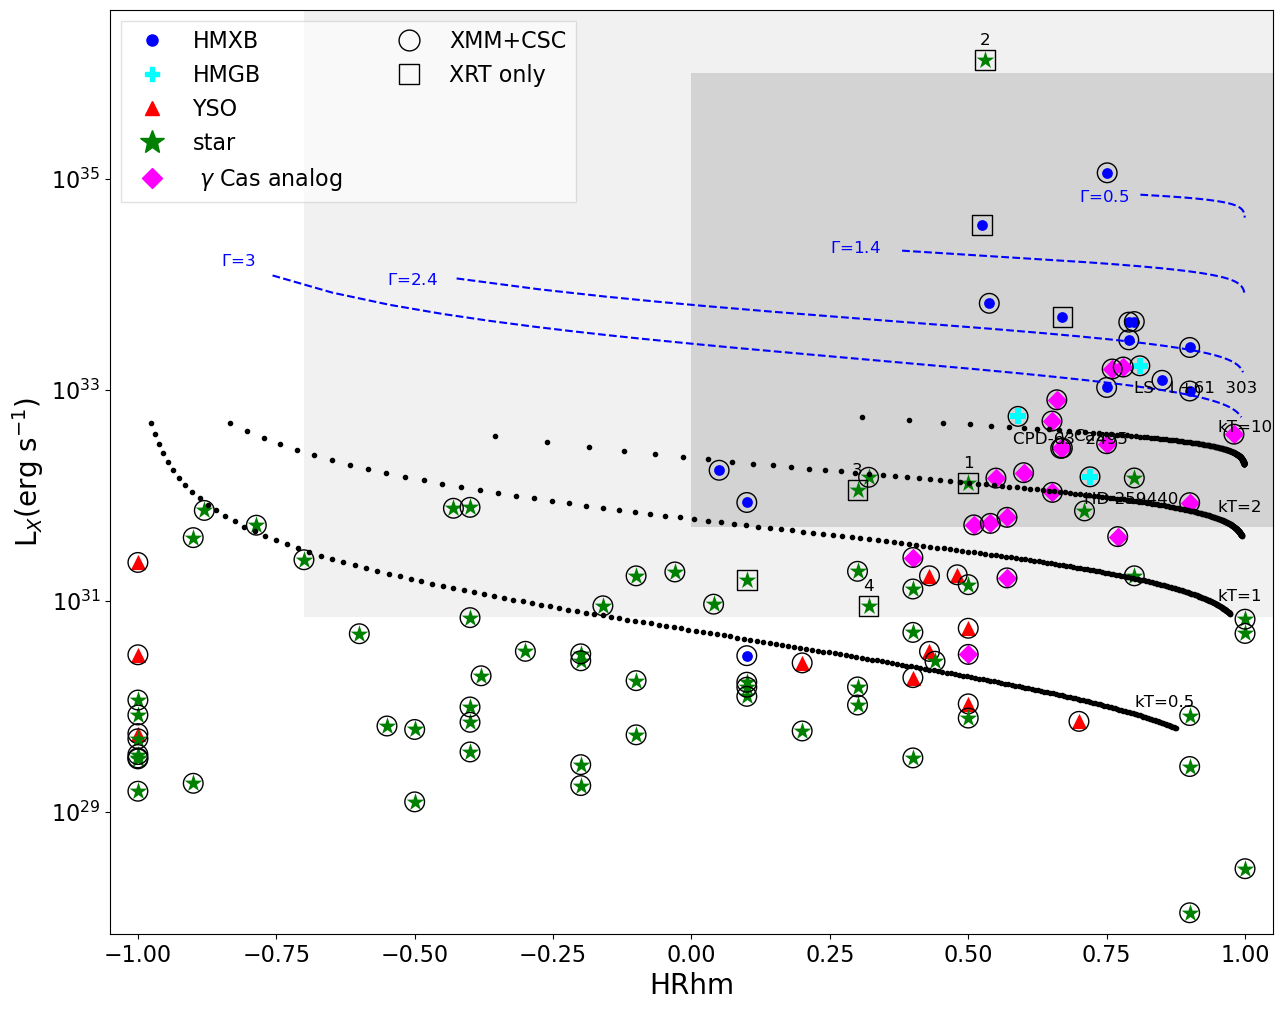

In [11]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,5e31),2.2,1e36, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=1))

ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2.2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))

for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
    
    for par in pars:
        df = pd.read_csv('./data/models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        if model == 'pl':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 * 20,line, color=color, label=model)
        elif model == 'gas':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 /5e3,line, color=color, label=model)

ax.text(0.95, 4e32, 'kT=10', fontsize=12)
ax.text(0.95, 7e31, 'kT=2', fontsize=12)
ax.text(0.95, 1e31, 'kT=1', fontsize=12)
ax.text(0.8, 1e30, 'kT=0.5', fontsize=12)

ax.text(0.7, 6e34, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(0.25, 2e34, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.55, 1e34, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.85, 1.5e34, '$\\Gamma$=3', fontsize=12, color='b')


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HRhm", y="LX", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_h_ms','LX']])
        ax.text(master_xray.loc[i,'HRhm']-0.01, master_xray.loc[i,'LX']*0.55, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRhm']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,5), ['HD 298369',  'HD 305560', 'HD 228256',  'HD  19818']):
    #print(i, master_xray[master_xray['main_id']==src]['HR_h_ms']-0.01)
    
    ax.text(master_xray.loc[master_xray['main_id']==src,'HRhm']-0.01, master_xray.loc[master_xray['main_id']==src,'LX']*1.4, str(i), fontsize=12)
    #print(i)
#'''    

ax.set(ylim=(7e27,4e36), xlim=(-1.05,1.05),  yscale="log", xlabel=r'HRhm', ylabel=r"L$_X$(erg s$^{-1}$)")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]
               
                
legend = ax.legend(handles=legend_elements1+legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#legend = ax.legend(handles=legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#'''

fig.savefig("./data/plots/LX_vs_HRhm_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

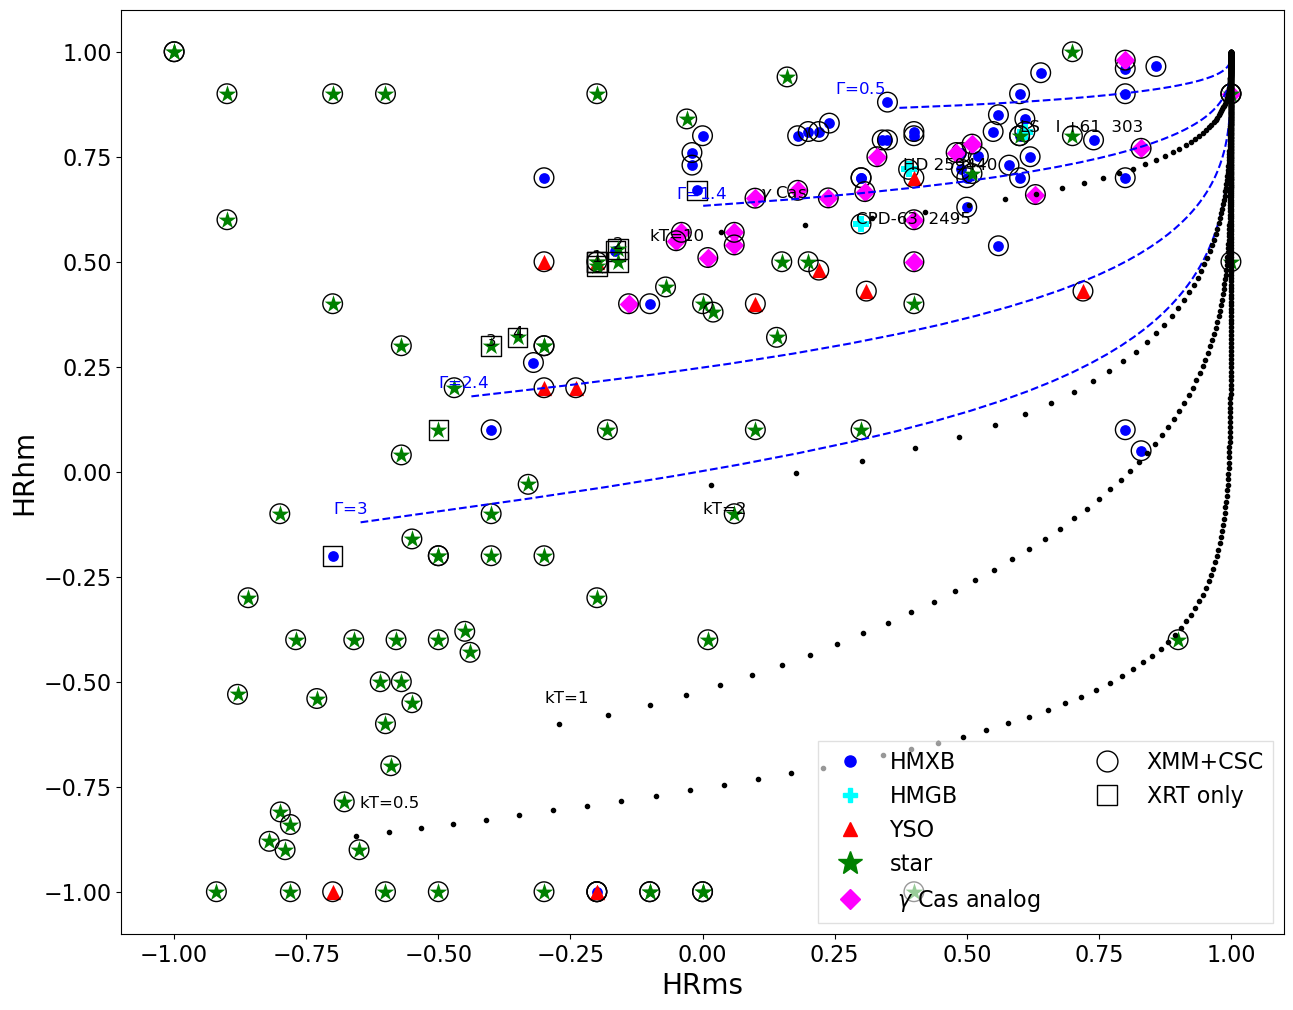

In [12]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
   
    for par in pars:
        df = pd.read_csv('./data/models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        ax.plot( (df['f2']-df['f1'])/(df['f2']+df['f1']), (df['f3']-df['f2'])/(df['f3']+df['f2']),line, color=color)
                   

ax.text(-0.1, 0.55, 'kT=10', fontsize=12)
ax.text(0., -0.1, 'kT=2', fontsize=12)
ax.text(-0.3, -0.55, 'kT=1', fontsize=12)
ax.text(-0.65, -0.8, 'kT=0.5', fontsize=12)

ax.text(0.25, 0.9, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(-0.05, 0.65, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.5, 0.2, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.7, -0.1, '$\\Gamma$=3', fontsize=12, color='b')

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HRms", y="HRhm", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRms"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRms"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRms']-0.01, master_xray.loc[i,'HRhm'], master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRms']+0.01, master_xray.loc[i,'HRhm'], r'$\gamma$ Cas', fontsize=12)

#for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
for i, src in zip(range(1,5), ['HD 298369',  'HD 305560', 'HD 228256',  'HD  19818']):
    ax.text(master_xray.loc[master_xray['main_id']==src,'HRms']-0.01, master_xray.loc[master_xray['main_id']==src,'HRhm'], str(i), fontsize=12)
    #print(i)
    
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]

legend = ax.legend(handles=legend_elements1+legend_elements2, loc='lower right', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("./data/plots/HRhm_vs_HRms_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

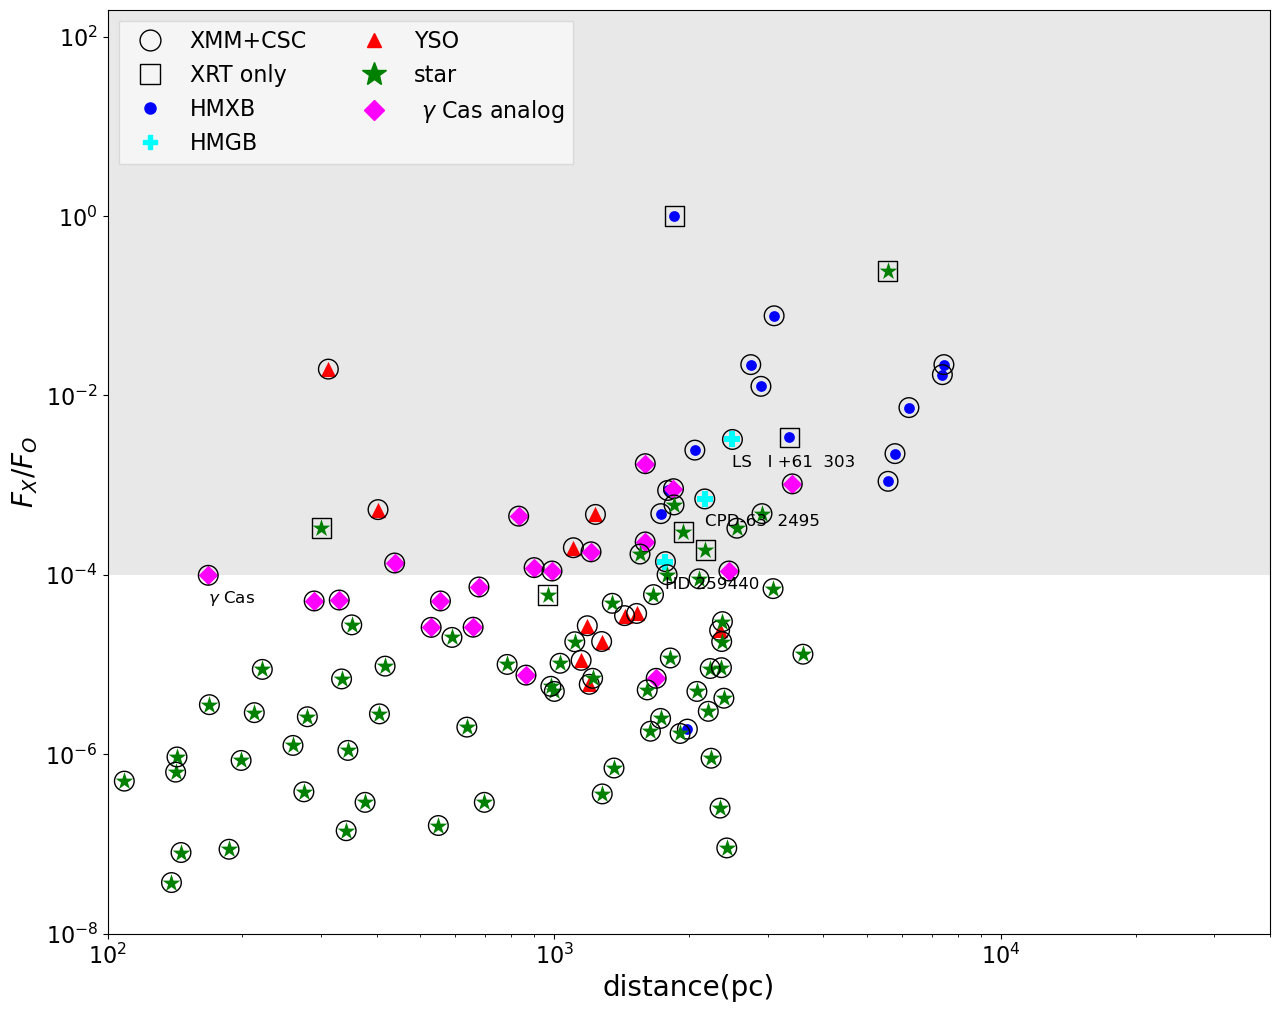

In [13]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="dist", y="fX2O", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'fX2O']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'fX2O']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(100,40000), xscale="log", yscale="log", xlabel='distance(pc)', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("./data/plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

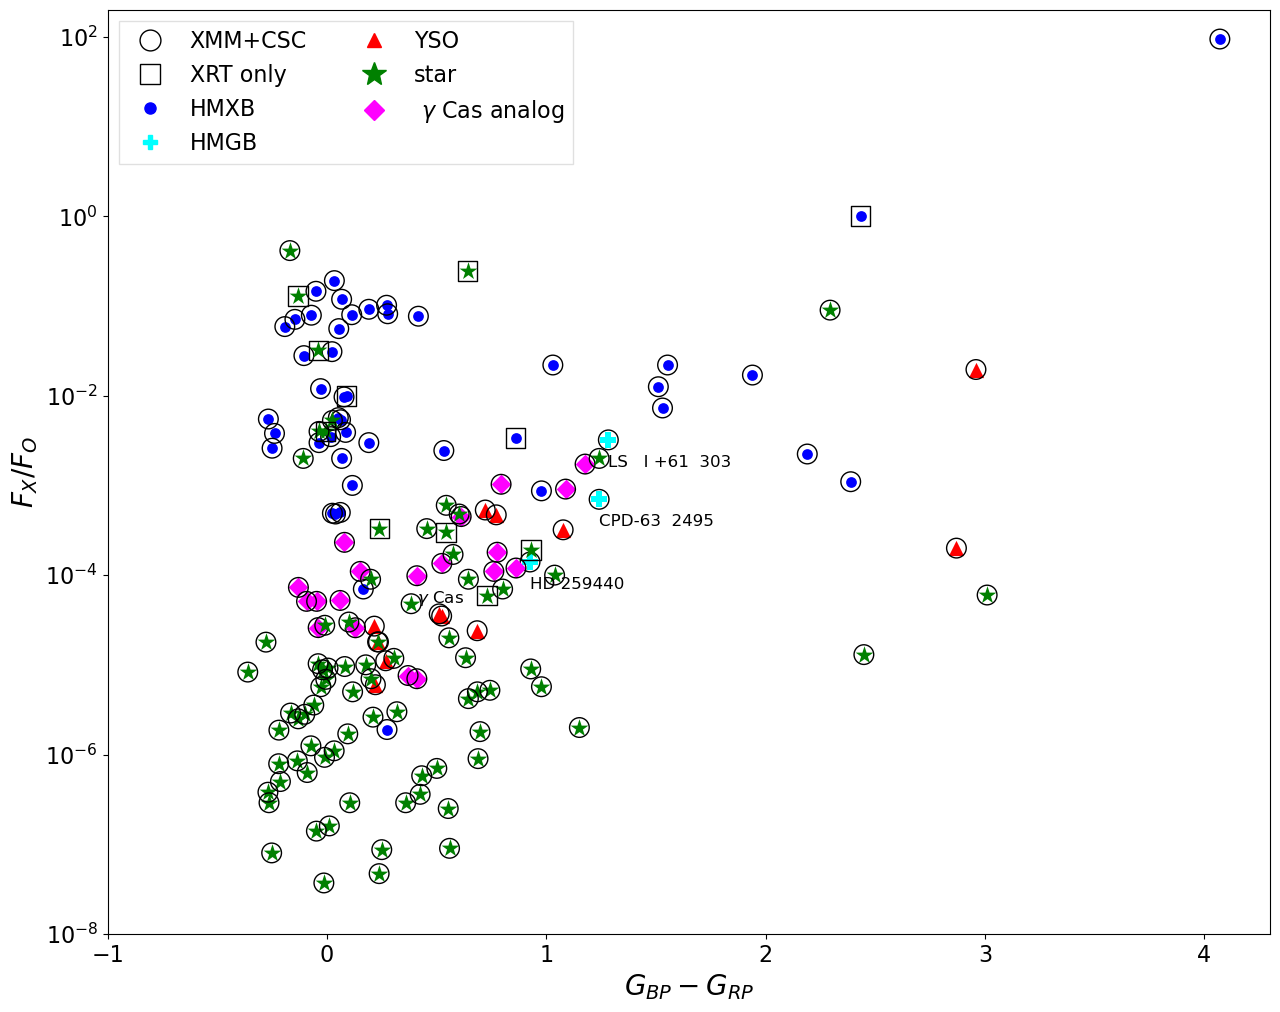

In [14]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="BP-RP", y="fX2O", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'fX2O']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'fX2O']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(-1,4.3), yscale="log", xlabel=r'$G_{BP}-G_{RP}$', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("./data/plots/fluxratio_vs_BP-RP_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

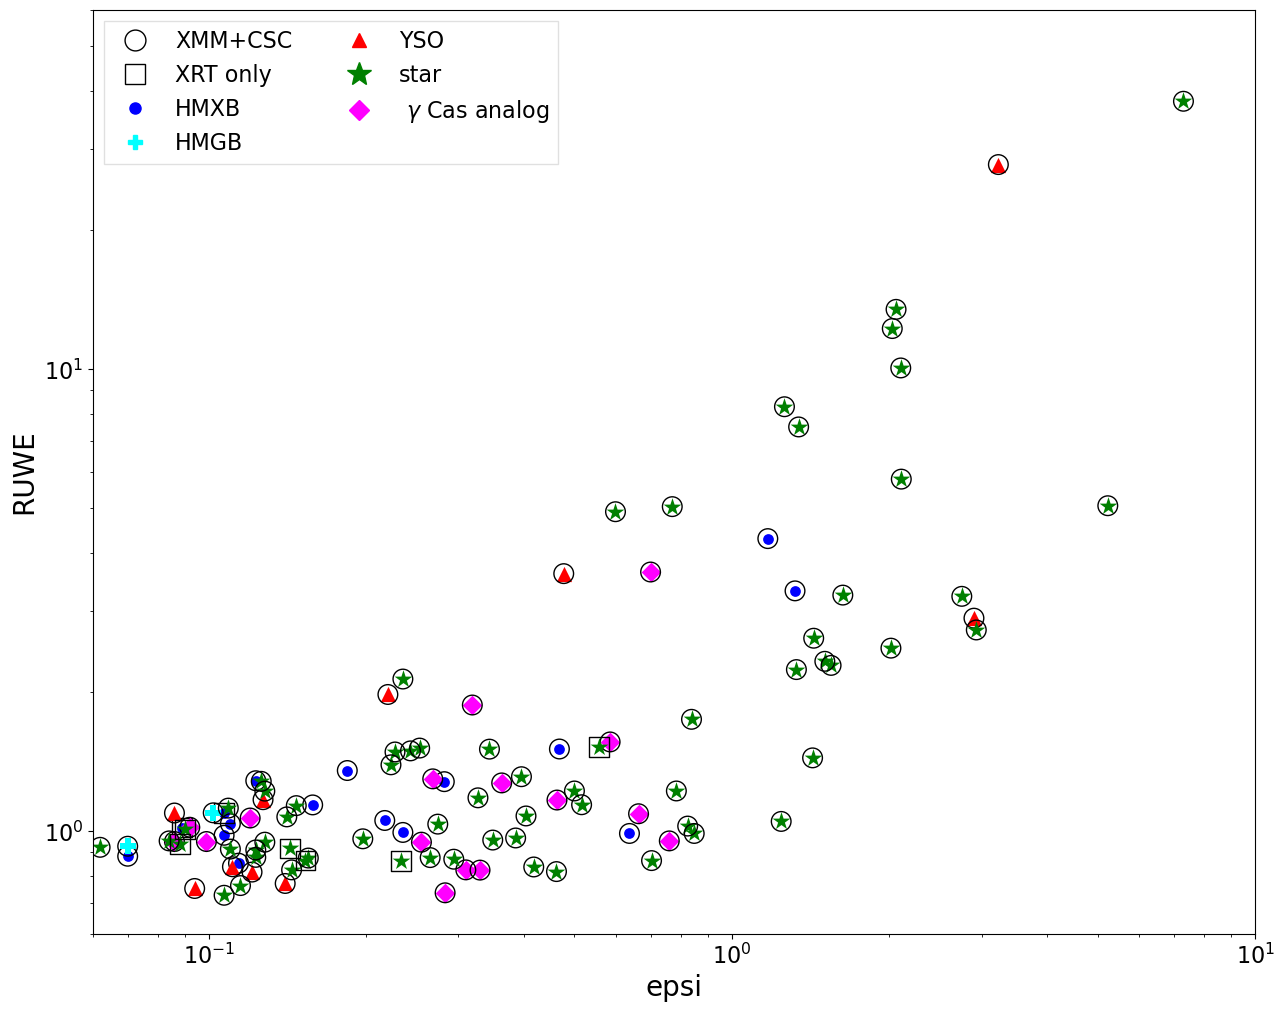

In [15]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas) & (master_xray['sepsi']>5)], x="epsi", y="RUWE", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


    
ax.set(xlim=(6e-2,10), ylim=(6e-1,60),  xscale="log", yscale="log", xlabel='epsi', ylabel="RUWE")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("./data/plots/RUWE_vs_epsi_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")